# MLLM-Microscope

## ScienceQA Dataset

In [1]:
from mllm_microscope import MllmMicroscope
from datasets import load_dataset, concatenate_datasets
import numpy as np

In [2]:
# Number of examples to sample
# N_EXAMPLES_IMG = 16
N_EXAMPLES_IMG = 64
# N_EXAMPLES_TXT = 250
N_EXAMPLES_TXT = 0
MAX_TOKENS = 16000  # Maximum number of tokens to aggregate in each layer

DATASET_NAME_LIST = ["lmms-lab/LLaVA-ReCap-118K", "derek-thomas/ScienceQA"]
DATASET_NAME = DATASET_NAME_LIST[0]
if DATASET_NAME == DATASET_NAME_LIST[0]:
    SPLIT = 'train'
else:
    SPLIT = 'test'

# Load the dataset
ds = load_dataset(DATASET_NAME)

if DATASET_NAME == DATASET_NAME_LIST[0]:
    sampled_indices = np.random.choice(len(ds[SPLIT]), N_EXAMPLES_IMG + N_EXAMPLES_TXT).tolist()
    sampled_entries = ds[SPLIT].select(sampled_indices)
else:
    # Filter the dataset into examples with and without images
    ds_with_image = ds[SPLIT].filter(lambda x: x['image'] is not None)
    ds_without_image = ds[SPLIT].filter(lambda x: x['image'] is None)
    
    # Sample N_EXAMPLES_IMG examples from the dataset with images
    img_sampled_indices = np.random.choice(len(ds_with_image), N_EXAMPLES_IMG, replace=False).tolist()
    img_samples = ds_with_image.select(img_sampled_indices)
    
    # Sample N_EXAMPLES_TXT examples from the dataset without images
    txt_sampled_indices = np.random.choice(len(ds_without_image), N_EXAMPLES_TXT, replace=False).tolist()
    txt_samples = ds_without_image.select(txt_sampled_indices)
    
    # Combine the samples using concatenate_datasets
    sampled_entries = concatenate_datasets([img_samples, txt_samples])

In [3]:
device = "cuda:1"
model_names = [
    "LLaVA-NeXT",
    "OmniFusion",
]

mllm_microscope = MllmMicroscope(device=device)

In [4]:
texts, images = [], []
for entry in sampled_entries:
    if DATASET_NAME == DATASET_NAME_LIST[0]:
        if len(texts) < N_EXAMPLES_IMG:
            image = entry['image']
            text = f"Description: {entry['conversations'][1]['value']}\nQuestion: Does the description correspond to the image?\nAnswer:"
        else:
            image = None
            text = f"Description: {entry['conversations'][1]['value']}\nQuestion: Can you imagine an image that corresponds to the description?\nAnswer:"
        
        texts.append(text)
        images.append(image)
    else:
        image = entry['image'] if entry['image'] else None
        # if not image: continue  # For now, skip the text-only examples
        question = entry['question']
        choices = entry['choices']
        answer = entry['answer']
        hint = entry['hint']
        lecture = entry['lecture']
        solution = entry['solution']
        # Prepare the question
        # text = f"Question: {question}\nChoices: {', '.join(choices)}\nLecture: {lecture}"
        text = f"Question: {question}\nChoices: {', '.join(choices)}"
        
        texts.append(text)
        images.append(image)

In [5]:
# Save the first image, which will be visualized
images[0].save("visualized_image.png", format="PNG")

In [6]:
# Obtain intermediate embeddings for LLaVA-NeXT
llava_next_embs = mllm_microscope.get_intermediate_embeddings(model_name=model_names[0], texts=texts, images=images, max_tokens=MAX_TOKENS)

Initializing the LLaVA-NeXT model...


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

LLaVA-NeXT Model Architecture:
LlavaNextForConditionalGeneration(
  (vision_tower): CLIPVisionModel(
    (vision_model): CLIPVisionTransformer(
      (embeddings): CLIPVisionEmbeddings(
        (patch_embedding): Conv2d(3, 1024, kernel_size=(14, 14), stride=(14, 14), bias=False)
        (position_embedding): Embedding(577, 1024)
      )
      (pre_layrnorm): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
      (encoder): CLIPEncoder(
        (layers): ModuleList(
          (0-23): 24 x CLIPEncoderLayer(
            (self_attn): CLIPSdpaAttention(
              (k_proj): Linear(in_features=1024, out_features=1024, bias=True)
              (v_proj): Linear(in_features=1024, out_features=1024, bias=True)
              (q_proj): Linear(in_features=1024, out_features=1024, bias=True)
              (out_proj): Linear(in_features=1024, out_features=1024, bias=True)
            )
            (layer_norm1): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
            (mlp): CLIPML

  0%|          | 0/64 [00:00<?, ?it/s]

[INST] <image>
Description: The image captures a dynamic scene of a skateboarder in action. The skateboarder, dressed in a striped sweater and khaki pants, is in the midst of performing a trick on a concrete ledge. The skateboard, with its black deck and white wheels, is tilted to the side, indicating the motion of the trick.

The skateboarder's arms are outstretched, aiding in balance and control. The background is a dark, brick building, providing a stark contrast to the brightly lit skateboarder. A sign reading "RESERVED PARKING 24 HRS" is visible in the background, suggesting that this might be a public space.

The image is taken from a low angle, looking up at the skateboarder. This perspective adds to the sense of motion and height, emphasizing the daring nature of the trick. The overall composition of the image suggests a moment of intense focus and skill.
Question: Does the description correspond to the image?
Answer: [/INST]


We detected that you are passing `past_key_values` as a tuple and this is deprecated and will be removed in v4.43. Please use an appropriate `Cache` class (https://huggingface.co/docs/transformers/v4.41.3/en/internal/generation_utils#transformers.Cache)
  2%|▏         | 1/64 [00:03<03:43,  3.55s/it]

[INST] <image>
Description: The image captures a dynamic moment in a baseball game. The central figures are the batter, the catcher, and the umpire. 

The batter, dressed in a crisp white uniform with the number 2 emblazoned on it, is in the midst of a powerful swing. His stance is one of concentration and strength, as he prepares to hit the incoming pitch.

Behind him, the catcher is crouched in anticipation. He's clad in a blue uniform with the number 41, ready to catch the ball if the batter misses. His position is one of readiness, his eyes focused on the incoming pitch.

The umpire, standing just behind the catcher, is dressed in a black uniform. He's attentively observing the play, ready to make a call. His position gives him a clear view of both the batter and the catcher, allowing him to make accurate judgments.

The scene is set against the backdrop of a well-maintained baseball field. The dirt infield is clearly visible, with the home plate and the batter's box marked out. Th

  3%|▎         | 2/64 [00:06<03:03,  2.95s/it]

[INST] <image>
Description: The image captures a cozy dining scene. At the center of the frame is a table, draped with a red and white checkered tablecloth. The table is set for two, with two plates of food and two glasses of red wine.

On the left side of the table, there's a plate of food that includes a serving of rice, a portion of black beans, and a piece of meat. The rice appears to be well-cooked, the black beans are dark and possibly seasoned, and the meat is browned, suggesting it might be grilled or roasted.

On the right side of the table, there's another plate of food. This one includes a serving of rice, a portion of black beans, and a piece of meat. The rice, beans, and meat are similar to the ones on the left plate, indicating that the meal is likely shared.

In front of each plate, there's a glass of red wine. The wine glasses are clear, allowing the rich red color of the wine to be visible. The glasses are filled to about half their capacity, suggesting that the meal i

  5%|▍         | 3/64 [00:07<02:15,  2.23s/it]

[INST] <image>
Description: The image depicts a cozy tea setting on a wooden table. In the center, there's a white teapot with gold accents, adorned with a floral pattern. To the left of the teapot, there's a teacup with a matching saucer, both featuring a blue and white color scheme with a floral design.

On the right side of the teapot, there's a wooden cutting board with a handle, serving as a serving tray. On this board, there are two golden-brown biscuits, which appear to be freshly baked. Accompanying the biscuits are three small white bowls filled with different condiments one with a red jam, one with a yellow butter, and one with a brown sauce.

In the background, there's a white wall with horizontal paneling, and a wooden chair is partially visible on the left side of the image. The overall setting suggests a warm and inviting atmosphere, likely in a home or a small café.
Question: Does the description correspond to the image?
Answer: [/INST]


  6%|▋         | 4/64 [00:08<01:48,  1.80s/it]

[INST] <image>
Description: The image shows a wooden cutting board with various chopped vegetables and a whole broccoli floret. On the left side of the board, there are sliced red bell peppers, and in the center, there are chopped onions. To the right, there are sliced yellow bell peppers. A whole broccoli floret is placed on the right side of the board. A knife with a black handle is resting on the board, suggesting it was used for chopping the vegetables. In the background, there is a glimpse of a kitchen counter with a red lidded container and a white appliance, possibly a refrigerator. The image captures a moment in the process of food preparation, with the focus on the fresh ingredients and the knife used for cutting.
Question: Does the description correspond to the image?
Answer: [/INST]


  8%|▊         | 5/64 [00:09<01:32,  1.56s/it]

[INST] <image>
Description: In the image, a young man is captured in the midst of a daring skateboard trick on a vibrant, mosaic-tiled bench. The bench, adorned with a riot of colors, serves as a striking backdrop to the scene. The skateboarder, dressed in a casual ensemble of a white t-shirt and black pants, is skillfully balancing on the edge of the bench with his skateboard. His body leans forward, indicating the momentum of his movement. The skateboard, under his control, is positioned on the right side of the bench, ready to spring back into action.

The setting appears to be an urban park or a similar public space, characterized by a concrete ground and a wall in the background. The wall is not just any wall, but a canvas for street artists, adorned with colorful graffiti that adds to the overall vibrancy of the scene. The graffiti includes various elements such as stars, buildings, and text, creating a dynamic and lively atmosphere.

The image beautifully captures a moment of ac

  9%|▉         | 6/64 [00:11<01:26,  1.49s/it]

[INST] <image>
Description: The image depicts a tranquil rural scene. A group of **six sheep**, their coats a mix of white and black, are huddled together in the foreground. They are standing on a bed of straw, which is scattered around them, suggesting a comfortable resting area.

The sheep are enclosed within a **wooden fence**, which is topped with a strand of barbed wire, indicating a secure boundary. The fence is made of wooden posts and wire, providing a rustic charm to the scene.

In the background, there's a **tree** with bare branches, hinting at a colder season. The tree stands tall, its silhouette contrasting with the low-lying sheep.

The sky above is a clear **blue**, suggesting a bright and sunny day. The overall scene is peaceful and idyllic, capturing a moment of calm in the countryside.
Question: Does the description correspond to the image?
Answer: [/INST]


 11%|█         | 7/64 [00:11<01:12,  1.27s/it]

[INST] <image>
Description: The image shows a large truck with a trailer designed to transport livestock. The trailer is divided into multiple compartments, each with a white metal fence structure that appears to be designed to secure the animals. The truck is predominantly white with blue trim along the bottom of the trailer. The cab of the truck is visible on the right side of the image, and it is a light color, possibly beige or light gray.

The trailer is filled with a large number of animals, which appear to be sheep or goats, based on their size and the shape of their heads. The animals are densely packed, with some standing and others lying down. They have a light-colored wool or fur, and their heads are visible through the gaps in the fencing.

The truck is parked, and there is no visible text or branding on the vehicle that would indicate the company or the origin of the truck. The background is nondescript, with a clear sky and no other objects or landmarks that provide conte

 12%|█▎        | 8/64 [00:13<01:11,  1.28s/it]

[INST] <image>
Description: The image shows a pizza in the process of being cooked. The pizza has a golden-brown crust with a slightly darker edge, indicating it's been baked. The toppings include what appears to be thinly sliced ham or prosciutto, chunks of white cheese that could be mozzarella, and green herbs that might be basil or a similar leafy vegetable. The pizza is placed on a metal surface, which could be a pizza peel or a pan, and it's positioned in front of a brick oven with visible heating elements above it. The oven interior is dark, and the light is focused on the pizza, highlighting its details. The image has a warm, inviting tone, suggesting a cozy and appetizing atmosphere.
Question: Does the description correspond to the image?
Answer: [/INST]


 14%|█▍        | 9/64 [00:14<01:09,  1.27s/it]

[INST] <image>
Description: In the image, a baby is peacefully sleeping on a white pillow. The baby is dressed in a white onesie adorned with yellow flowers. The baby is comfortably nestled under a pink blanket, which adds a soft contrast to the white pillow.

On either side of the baby, there are two brown teddy bears. The teddy bear on the left is holding a red bottle of Dr. Pepper, while the teddy bear on the right is holding a red bottle of Dr. Pepper. The teddy bears seem to be guardians of the sleeping baby, providing a sense of comfort and security.

The entire scene is set against a beige couch, which provides a neutral backdrop that allows the colors in the image to stand out. The overall atmosphere of the image is one of tranquility and warmth, with the sleeping baby as the centerpiece.
Question: Does the description correspond to the image?
Answer: [/INST]


 16%|█▌        | 10/64 [00:15<01:04,  1.20s/it]

[INST] <image>
Description: In the image, there are two men standing on a concrete surface. The man on the left is seated on a green motorcycle with a yellow and black number "K57" on the front. He is wearing a black leather jacket and a pair of black boots. His arms are crossed, and he is smiling at the camera.

Standing next to him is another man who is wearing a beige jacket and blue jeans. He is also smiling and looking at the camera.

In the background, there is a red and white striped pole and a blue sign with a white arrow pointing to the left. The sky is cloudy, suggesting it might be a cool or overcast day.

The motorcycle has a black seat and a silver exhaust pipe. The number "168" is also visible on the front of the motorcycle. The overall scene suggests that these two men might be preparing for a ride or have just finished one.
Question: Does the description correspond to the image?
Answer: [/INST]


 17%|█▋        | 11/64 [00:16<01:02,  1.18s/it]

[INST] <image>
Description: The image shows an interior view of a hotel room, focusing on the bed area. The bed is large and appears to be a king-size with a white bedspread and a red bed runner at the foot. There are two white pillows at the head of the bed. The room has a modern design with a dark brown accent wall behind the bed, which contrasts with the lighter colors of the bed linens and the white wall to the left.

On the left side of the bed, there is a nightstand with a lamp that has a pink shade, casting a warm glow on the wall. Above the nightstand, there is a decorative piece of wall art with a floral pattern. The room is well-lit, with a combination of natural light coming through the window, which is covered with red curtains, and artificial light from the lamp.

The overall ambiance of the room is cozy and inviting, with a color scheme that includes shades of red, white, and brown. The room is clean and well-maintained, suggesting it is ready for guests. There are no vis

 19%|█▉        | 12/64 [00:17<01:03,  1.21s/it]

[INST] <image>
Description: The image depicts a serene harbor scene. In the foreground, there's a **blue and white boat** with the registration number **1098225**. The boat is docked at a pier, and there's a person standing on the deck, possibly overseeing the boat or preparing for a journey.

In the background, there are several other boats of various sizes and colors, all docked and bobbing gently on the water. The harbor is nestled amidst lush green trees and buildings, adding a touch of urban life to the otherwise natural landscape.

The sky above is a clear blue, suggesting a bright and sunny day. The calm water reflects the colors of the boats and the surrounding environment, creating a beautiful and peaceful atmosphere.

Overall, the image captures a moment of tranquility in a bustling harbor, with the boats waiting patiently for their next voyage.
Question: Does the description correspond to the image?
Answer: [/INST]


 20%|██        | 13/64 [00:20<01:27,  1.73s/it]

[INST] <image>
Description: The image shows a close-up of a cat with striking blue eyes. The cat has a coat that appears to be a mix of white and dark brown or black, with the dark color concentrated around the ears, face, and tail. The cat's eyes are wide open, and its gaze is directed towards something outside the frame, giving it a focused and attentive expression. The cat's whiskers are clearly visible, and its ears are perked up, suggesting alertness. The background is blurred, which puts the emphasis on the cat's face. The lighting in the photo is soft, with no harsh shadows, which highlights the cat's fur texture and the color of its eyes.
Question: Does the description correspond to the image?
Answer: [/INST]


 22%|██▏       | 14/64 [00:21<01:11,  1.43s/it]

[INST] <image>
Description: The image shows two different species of animals in a natural setting. In the foreground, there is a large bird with a long neck and a distinctive head shape, which appears to be an ostrich. The ostrich is facing the camera, and its feathers are a light color, possibly white or cream.

In the background, there is a giraffe, which is characterized by its long neck and legs, and its distinctive spotted coat pattern. The giraffe is facing to the left of the frame, and its head is turned slightly towards the camera. The giraffe's coat is a mix of brown and white patches.

Both animals are standing in a wooded area with trees and foliage in the background. The lighting suggests it might be daytime, and the overall atmosphere of the image is serene and natural. There are no visible texts or distinguishing marks that provide additional context about the location or the circumstances under which the photo was taken.
Question: Does the description correspond to the i

 23%|██▎       | 15/64 [00:22<01:00,  1.24s/it]

[INST] <image>
Description: In the image, a man is seen standing on a sidewalk, waving his hand towards a yellow school bus that is parked on the street. The bus is large and yellow, with its doors closed. The man is dressed in a blue jacket and is standing next to a bicycle that is leaning against a brick wall. The bicycle has a black seat and handlebars.

The scene is set in a suburban neighborhood, with houses visible in the background. The sky above is overcast, suggesting that it might be a cloudy day. The man's action of waving towards the bus could indicate that he is either greeting someone on the bus or signaling to the bus driver. The overall atmosphere of the image is calm and peaceful, typical of a quiet neighborhood.
Question: Does the description correspond to the image?
Answer: [/INST]


 25%|██▌       | 16/64 [00:23<00:56,  1.17s/it]

[INST] <image>
Description: In the image, a person is skateboarding down a steep, curving road. The skateboarder is wearing a black helmet and a black shirt, and they are crouched low on their skateboard, which is black as well. The road is paved and appears to be in good condition, with a yellow line running down the middle.

On the left side of the road, there is a fence made of metal poles and wire. The fence is topped with barbed wire, suggesting that it might be a security fence. On the right side of the road, there is a grassy area with trees and bushes.

In the background, there are buildings that appear to be industrial or commercial in nature. The sky is clear and blue, indicating that it is a sunny day. The overall scene suggests that the skateboarder is enjoying a sunny day outdoors, taking advantage of the empty road to practice their skateboarding skills.
Question: Does the description correspond to the image?
Answer: [/INST]


 27%|██▋       | 17/64 [00:24<00:50,  1.07s/it]

[INST] <image>
Description: In the image, there are two individuals seated on a vibrant red couch adorned with a pattern of white flowers. The person on the left is holding a laptop that is covered in a variety of colorful stickers, including one that reads "Free" and another that says "Fire Eagle". The individual on the right is also holding a laptop, which is similarly decorated with stickers, including one that reads "CC". Both individuals are smiling, suggesting a positive and friendly atmosphere. The background is blurred, but it appears to be a room with a red wall and a window, adding to the overall warm and inviting ambiance of the scene.
Question: Does the description correspond to the image?
Answer: [/INST]


 28%|██▊       | 18/64 [00:25<00:48,  1.06s/it]

[INST] <image>
Description: The image shows a blender with a clear pitcher that is filled with a green liquid, possibly a smoothie or juice. The blender is placed on a wooden surface, and it is plugged into an electrical outlet on a brick wall. The blender has a white base with a control panel that includes buttons and a digital display. The lid of the blender is missing, and it appears to be taped over with gray duct tape, suggesting that the blender may be damaged or in need of repair. The overall setting suggests a casual, possibly domestic environment.
Question: Does the description correspond to the image?
Answer: [/INST]


 30%|██▉       | 19/64 [00:26<00:46,  1.04s/it]

[INST] <image>
Description: In the heart of a bustling city, a daring skateboarder takes flight, soaring over a series of white cones that mark his path. The skateboarder, dressed in a casual ensemble of a t-shirt and jeans, is captured mid-air, his body suspended above the skateboard as he executes a daring trick. His arms are outstretched, aiding his balance as he defies gravity.

The scene unfolds on a street that has been transformed into a makeshift skate park. The white cones, scattered haphazardly, serve as obstacles for the skateboarder to navigate. They stand out starkly against the backdrop of the city, drawing attention to the spectacle unfolding before them.

In the background, a group of spectators watches the spectacle unfold. Their faces are a mix of awe and anticipation, their eyes following the skateboarder's every move. Their presence adds a sense of community and camaraderie to the scene, turning it into more than just a display of skill - it's a shared moment of exc

 31%|███▏      | 20/64 [00:27<00:45,  1.03s/it]

[INST] <image>
Description: In the image, an older man is engrossed in the art of kite making. He is standing at a table, which is covered with a variety of materials and tools. The man is wearing a black shirt and glasses, and he appears to be in the process of folding a pink kite.

The table is a hub of activity, with several kites in various stages of completion. There are also scissors and a ruler, essential tools for precise measurements and cutting. A sewing machine is also present, indicating that some parts of the kites might be sewn together.

The room around the table is filled with books, suggesting that the man might be following a specific pattern or design for his kites. The walls are adorned with paintings, adding a touch of creativity to the space.

In the background, there's a couch and a chair, providing a comfortable seating area. The overall atmosphere of the room is one of creativity and craftsmanship.
Question: Does the description correspond to the image?
Answer:

 33%|███▎      | 21/64 [00:29<00:58,  1.35s/it]

[INST] <image>
Description: The image shows two open suitcases placed side by side on a floor. The left suitcase is larger and appears to be filled with various items, including what looks like clothing and possibly some personal belongings. The right suitcase is smaller and contains a white laptop on top, with some papers or documents underneath. To the right of the suitcases, there is a small, colorful toy with a smiling face, which seems to be a character from a children's show or book. The toy has a yellow body, a red hat, and a red and yellow striped shirt. The background is a plain, light-colored wall, and the floor is tiled. There are no visible texts or distinctive brands in the image. The style of the image is a straightforward, candid photograph with no artistic filters or effects applied.
Question: Does the description correspond to the image?
Answer: [/INST]


 34%|███▍      | 22/64 [00:30<00:52,  1.25s/it]

[INST] <image>
Description: The image shows a stop sign with the word "BUSH" added below the word "STOP" in a bold, capitalized font. The stop sign is red with white lettering and is mounted on a metal pole. The sign has been vandalized with graffiti, as indicated by the word "BUSH" and additional scribbles in white paint. The background of the image features a street scene with a red car parked on the side of the road, and there are trees and a building visible in the distance. The sky is partly cloudy, suggesting it might be a sunny day. The overall style of the image is a candid, real-life photograph with no apparent artistic filters or effects applied.
Question: Does the description correspond to the image?
Answer: [/INST]


 36%|███▌      | 23/64 [00:31<00:46,  1.13s/it]

[INST] <image>
Description: In the image, a young girl is the main subject, standing in the foreground on a lush green lawn. She is dressed in a white tank top and blue plaid shorts, and she has blonde hair. The girl is looking up at a yellow frisbee that is in mid-air, suggesting she might be playing with it.

Behind the girl, there is a large, gray stone house with a prominent turret. The house has multiple windows and a gray roof, giving it a grand and imposing appearance. The house is surrounded by a well-maintained lawn, which extends to the foreground where the girl is standing.

The sky above is overcast, casting a soft light over the scene. The overall atmosphere of the image is peaceful and serene, with the girl's activity adding a touch of liveliness to the otherwise tranquil setting.
Question: Does the description correspond to the image?
Answer: [/INST]


 38%|███▊      | 24/64 [00:32<00:41,  1.05s/it]

[INST] <image>
Description: The image depicts a snowy landscape with a person engaged in winter sports. The person appears to be snowboarding, as they are standing on a snowboard and are positioned in a stance that suggests they are either preparing to descend a slope or have just completed a run. They are wearing dark clothing, which contrasts with the white snow, and their body is angled slightly to the side, indicating movement or preparation for movement.

The background features a series of snow-covered slopes and hills, with trees scattered across the landscape. The trees are also covered in snow, suggesting recent snowfall or a well-preserved snowpack. The sky is overcast, with no visible blue sky, which contributes to the wintry atmosphere of the scene.

The image is taken from a distance, capturing the person and the surrounding environment in a single frame. The focus is on the person and their immediate surroundings, with the background slightly blurred, which helps to draw 

 39%|███▉      | 25/64 [00:32<00:36,  1.06it/s]

[INST] <image>
Description: The image captures a lively street scene in a city. The street is bustling with people, some of whom are walking, while others are standing, possibly waiting or just enjoying the atmosphere. The buildings lining the street are a mix of brick and stone, with a variety of architectural styles, suggesting a rich history.

On the left side of the street, there's a blue building with a sign that reads "Wesport". This could be a shop or a business establishment. Further down the street, there's a green building with a sign that reads "Strad Grafton Street". This might be another shop or business.

The street is adorned with several street signs, including one that reads "Bara on Temple Bar" and another that reads "The Environmental Information Service". These signs provide directions and information to the pedestrians.

The sky above is clear, suggesting a sunny day. The overall scene is vibrant and full of life, typical of a busy city street.
Question: Does the d

 41%|████      | 26/64 [00:34<00:39,  1.05s/it]

[INST] <image>
Description: The image depicts a group of people walking on a cobblestone street during what appears to be a rainy day. In the foreground, there are three individuals who are more prominently featured. The person on the left is wearing a black jacket, blue jeans, and brown boots, and is carrying a colorful bag. The individual in the center is holding a pink umbrella and is wearing a black jacket, black pants, and black boots. The person on the right is also holding an umbrella, which is black, and is wearing a black jacket, a patterned scarf, blue jeans, and black boots.

In the background, there are several other people walking, some of whom are also holding umbrellas. The architecture suggests a European setting, possibly Paris, given the style of the buildings and the cobblestone street. The sky is overcast, and the ground is wet, indicating recent or ongoing rain. The overall atmosphere of the image is one of a typical rainy day in a city.
Question: Does the descript

 42%|████▏     | 27/64 [00:35<00:39,  1.08s/it]

[INST] <image>
Description: In the image, there are two black and white dogs peacefully sleeping in a green pet bed. The bed is lined with a white cushion, providing a soft and comfortable surface for the dogs. The dog on the left is curled up in a ball, its head resting on its paws, while the dog on the right is lying on its side, its head resting on the cushion. 

Scattered around the bed are three stuffed animals, adding a playful touch to the scene. There's a red stuffed animal on the left, a purple one in the middle, and a pink one on the right. The dogs seem to be in a deep sleep, undisturbed by their surroundings. The image captures a moment of tranquility and comfort for these two pets.
Question: Does the description correspond to the image?
Answer: [/INST]


 44%|████▍     | 28/64 [00:36<00:38,  1.06s/it]

[INST] <image>
Description: The image is a captivating representation of an impressionist still life painting. The scene is set on a table draped with a pristine white tablecloth. The table hosts a variety of objects, each contributing to the overall composition.

On the left side of the table, there's a vibrant red shell, its color contrasting beautifully with the white tablecloth. Next to it, a white coffee cup with a black handle adds a touch of elegance. A yellow lemon, its bright hue adding a pop of color, is also present on the table.

On the right side of the table, a black clock with a white face stands out against the lighter tones of the other objects. The clock's presence adds a sense of time to the scene.

In the background, a black vase with a white handle can be seen. Its dark color provides a nice contrast to the lighter objects in the foreground.

The painting is executed in an impressionist style, characterized by loose brushstrokes and a focus on the interplay of ligh

 45%|████▌     | 29/64 [00:37<00:38,  1.11s/it]

[INST] <image>
Description: The image depicts an indoor scene, likely a fruit and vegetable stall or market stand. In the foreground, there is a person with dark hair, wearing a striped shirt, who appears to be a customer or possibly a vendor. The person is facing away from the camera, looking towards the fruit display.

The fruit display is abundant and colorful, with a variety of produce. There are several bunches of ripe bananas hanging from a metal rod, which spans the width of the image. Below the bananas, there are shelves stocked with various packaged goods, including what looks like canned items and possibly some snacks or beverages.

In the foreground, there are boxes of apples, with the visible ones being red and green, suggesting they are fresh and possibly for sale. The apples are neatly arranged in boxes, and there is a price tag visible, indicating that they are for sale.

The lighting in the image is bright, suggesting an indoor environment with artificial lighting. The 

 47%|████▋     | 30/64 [00:38<00:35,  1.04s/it]

[INST] <image>
Description: The image shows a cake designed to resemble a black top hat and a white glove, which are iconic symbols associated with the character of Michael Jackson. The cake is placed on a red plate with white stars around the edge. The hat is positioned on top of the plate, and the glove is placed to the side. The cake is decorated with white icing to mimic the appearance of the hat and glove.

On the hat, there is a message written in white icing that reads "Happy 55th Birthday MICHAEL." The text is arranged in a way that the word "Happy" is at the top, "55th" is in the middle, and "Birthday MICHAEL" is at the bottom. The stars on the plate are also made of white icing.

The background of the image is a tablecloth with a floral pattern, and there is a glass with a yellowish liquid in the top left corner of the image. The overall style of the image is a close-up photograph with a focus on the cake, capturing the details of the decoration and the message.
Question: Doe

 48%|████▊     | 31/64 [00:40<00:43,  1.30s/it]

[INST] <image>
Description: In the image, a person is standing in a grassy field, their body angled towards the right side of the frame. They are dressed in a blue shirt and brown pants, and are holding a black and white kite string in their right hand. The kite, which is black and white, is soaring high in the sky, positioned in the top right corner of the image. The person's gaze is directed upwards, following the path of the kite. In the background, there are trees and buildings, adding depth to the scene. The sky above is filled with clouds, suggesting an overcast day. The overall scene captures a moment of leisure and enjoyment of outdoor activities.
Question: Does the description correspond to the image?
Answer: [/INST]


 50%|█████     | 32/64 [00:41<00:40,  1.27s/it]

[INST] <image>
Description: The image depicts an urban landscape with a focus on transportation infrastructure. In the foreground, there is a train on a track, with a green and yellow passenger car and a black locomotive. The train is stationary, and the tracks appear to be part of a larger network.

In the middle ground, there is a large construction site with a yellow crane, indicating ongoing development. The site is surrounded by a fence, and there are several construction materials visible, including what appears to be scaffolding and building components.

The background features a mix of buildings, including a prominent yellow building with many windows, which could be an apartment complex or commercial building. There are also other structures, some with red roofs, suggesting a variety of architectural styles and purposes.

A red bridge spans over the train tracks, connecting different parts of the city. The bridge has a distinctive red color and a sturdy appearance, likely desi

 52%|█████▏    | 33/64 [00:42<00:39,  1.26s/it]

[INST] <image>
Description: The image shows a computer desk with two monitors side by side. The left monitor displays a desktop with various icons and a wallpaper that includes multiple photographs of birds and nature scenes. The right monitor shows a web browser with a webpage open, displaying a list of items or data.

On the desk, there is a black keyboard in front of the monitors, and to the right of the keyboard, there is a black mouse. To the left of the keyboard, there is a black stapler. In the center of the desk, there is a black mug with a yellow lid, and to the right of the mug, there is a small yellow box with a black label.

The desk appears to be in an office environment, as suggested by the presence of the monitors, keyboard, and mouse, which are typical office equipment. The desk is cluttered with various items, indicating that it is actively used. The image is a photograph and captures the scene from a slightly elevated angle, providing a clear view of the desk and its 

 53%|█████▎    | 34/64 [00:43<00:35,  1.19s/it]

[INST] <image>
Description: In the image, a man is captured in the midst of a delightful culinary experience. He's seated at a table, his attention fully absorbed by the glazed donut he's about to take a bite of. His eyes are closed, perhaps in anticipation of the sweet treat, and his mouth is open wide, ready to savor the moment.

The man is dressed in a black jacket, which contrasts with the white shirt he's wearing underneath. His glasses add a touch of sophistication to his appearance. The table in front of him is adorned with a white tablecloth, providing a clean and simple backdrop for the scene.

The setting appears to be a restaurant or cafe, as suggested by the blurred background. The focus is solely on the man and his donut, making it the centerpiece of this image. The overall composition of the photo suggests a moment of simple pleasure, frozen in time.
Question: Does the description correspond to the image?
Answer: [/INST]


 55%|█████▍    | 35/64 [00:44<00:32,  1.12s/it]

[INST] <image>
Description: In the heart of the image, a white teddy bear with pink ears and a pink snout is the star of the scene. The teddy bear, adorned with a pink bow around its neck, is comfortably seated on a beige carpeted floor. It's engrossed in a yellow book that it holds in its paws, suggesting a love for reading.

The teddy bear is positioned in front of a wooden chair, which adds a touch of rustic charm to the scene. The chair is situated on a blue and white patterned rug, adding a splash of color to the otherwise neutral tones of the room.

The teddy bear's position on the floor and its engagement with the book create an atmosphere of quiet contemplation and learning. It's as if the teddy bear is inviting us to join it in its cozy corner of the room, to pick up a book and lose ourselves in its pages.
Question: Does the description correspond to the image?
Answer: [/INST]


 56%|█████▋    | 36/64 [00:45<00:31,  1.12s/it]

[INST] <image>
Description: The image shows a motorcycle parked on a sandy terrain with grass and shrubs in the background. The motorcycle is a black and silver color, with a visible license plate that reads "755022". The bike is equipped with a large blue saddlebag on the back, suggesting it is designed for long rides or touring. The handlebars are equipped with rearview mirrors and there is a small screen or fairing in front of the handlebars, which is typical for motorcycles designed for better aerodynamics and rider comfort. The motorcycle also has a visible exhaust pipe on the right side. The tires appear to be off-road or dual-sport type, with deep treads for better grip on various surfaces. The overall style of the image is a natural, outdoor setting with a focus on the motorcycle, which is the main subject of the photograph.
Question: Does the description correspond to the image?
Answer: [/INST]


 58%|█████▊    | 37/64 [00:46<00:29,  1.09s/it]

[INST] <image>
Description: The image shows a male tennis player in a white outfit, which includes a polo shirt and shorts, standing on a tennis court. He is holding a tennis racket with both hands, ready to play. The player is wearing a white cap and has a focused expression on his face, suggesting he is concentrating on the game. In the background, there are other individuals, likely spectators or officials, but they are not the main focus of the image. The setting appears to be an outdoor tennis court, as indicated by the green surface and the presence of a crowd. The style of the image is a candid photograph, capturing a moment during a tennis match.
Question: Does the description correspond to the image?
Answer: [/INST]


 59%|█████▉    | 38/64 [00:47<00:26,  1.01s/it]

[INST] <image>
Description: The image shows a neatly arranged hotel room with a large bed as the central focus. The bed has a beige headboard and is dressed with a white bedspread that has a subtle gray stripe pattern. There are multiple pillows on the bed, including two larger ones at the head and two smaller ones at the foot, all covered in white pillowcases. A gray throw blanket is folded at the foot of the bed, adding a touch of color to the otherwise neutral palette.

On either side of the bed, there are nightstands with lamps that have yellow shades, providing a warm glow to the room. The lamps are turned on, illuminating the space. The room has a carpeted floor, and there is a window with sheer curtains to the left, allowing natural light to filter into the room. The overall ambiance of the room is calm and inviting, typical of a hotel setting designed for comfort and relaxation.
Question: Does the description correspond to the image?
Answer: [/INST]


 61%|██████    | 39/64 [00:49<00:28,  1.16s/it]

[INST] <image>
Description: The image depicts a modern bathroom interior. The bathroom features a dark color scheme with black marble or similar dark-toned countertops. On the countertop, there is a white oval-shaped sink with a silver faucet. To the right of the sink, there are various toiletries including a bottle of water, a green soap dispenser, and a white box that could be a tissue box or a small toiletry item. A white towel is neatly folded and placed on the countertop.

In the background, there is a bathtub with a pinkish hue, suggesting it might be a light-colored or possibly a pink bathtub. Above the bathtub, there is a mirror that reflects the interior of the bathroom, including the door and the wall. The door has a gold-colored handle and appears to be closed. The wall is adorned with dark-colored tiles that match the countertop.

The lighting in the bathroom is soft and ambient, creating a calm and luxurious atmosphere. The overall style of the bathroom suggests a contempo

 62%|██████▎   | 40/64 [00:49<00:24,  1.04s/it]

[INST] <image>
Description: In the image, a tranquil scene unfolds in a bedroom bathed in soft light. A woman, dressed in a black shirt, is comfortably nestled on a bed adorned with a vibrant quilt in hues of pink and purple. Her eyes are gently closed, suggesting a moment of rest or perhaps a brief nap.

The bed is not just a resting place for the woman, but also for her feline companions. Three cats, each with their own unique fur patterns, are scattered across the bed. One cat is perched on the woman's chest, perhaps seeking warmth or companionship. Another cat is lying on the bed near the woman's feet, while the third cat is resting on the quilt, close to the woman's side.

The room itself is simple yet cozy. A nightstand stands guard next to the bed, hosting a lamp that casts a warm glow across the room. The walls are painted in a soothing shade of green, adding to the overall calm and peaceful atmosphere of the scene.

Every object in this image, from the woman and her cats to th

 64%|██████▍   | 41/64 [00:51<00:24,  1.06s/it]

[INST] <image>
Description: The image captures a serene cityscape viewed from a high vantage point. Dominating the scene is a majestic clock tower, its gray spire reaching towards the sky. The tower is adorned with a gold weather vane at its peak, gleaming under the sunlight. Two clock faces, one on each side of the tower, display the time, their golden numbers and hands standing out against the gray stone.

The city below is a patchwork of red rooftops, interspersed with green trees that add a touch of nature to the urban landscape. The buildings, varying in height and design, create a sense of depth and scale. The perspective of the photo suggests it was taken from a nearby building, offering a bird's eye view of the city.

In the foreground, a black bird with a white chest is perched on a ledge, adding a touch of life to the scene. Its presence adds a sense of scale, emphasizing the grandeur of the clock tower and the cityscape beyond.

Overall, the image beautifully juxtaposes the 

 66%|██████▌   | 42/64 [00:52<00:25,  1.15s/it]

[INST] <image>
Description: The image shows a person playing tennis on a court. The individual is wearing a white polo shirt with a logo on the left chest, blue shorts with a number "11" on the left leg, and white tennis shoes with blue accents. They are holding a tennis racket in their right hand and appear to be in the middle of a swing, possibly returning a serve or hitting a ball. The person has short hair and is looking to the left side of the frame, which suggests they are focused on the ball or their opponent.

The tennis court has a green surface with white boundary lines, and there is a chain-link fence in the background, which is typical for outdoor tennis courts. The sky is clear, indicating good weather conditions for playing tennis. There is another person visible in the background, but they are not the main focus of the image. The style of the image is a candid, real-life photograph capturing an active moment during a tennis match.
Question: Does the description correspon

 67%|██████▋   | 43/64 [00:53<00:24,  1.17s/it]

[INST] <image>
Description: The image shows a close-up of a broccoli plant in its natural environment. The broccoli florets are in various stages of growth, with some appearing more mature and others still in the early stages of development. The florets are a vibrant green color, indicating freshness and good health. The plant's leaves are a deep purple-green hue, which is characteristic of certain varieties of broccoli. The background is slightly blurred, but it appears to be a garden or a field with other plants, suggesting that the broccoli is growing in an outdoor setting. The overall image has a naturalistic feel, capturing the plant in its habitat.
Question: Does the description correspond to the image?
Answer: [/INST]


 69%|██████▉   | 44/64 [00:54<00:21,  1.07s/it]

[INST] <image>
Description: The image depicts a scene at a bus stop. A group of people are waiting to board a bus. The bus is a blue and white color, and it is parked at the curb. The people are standing on the sidewalk, and they are carrying various items such as backpacks and handbags. The bus stop is located under a bridge, and there are signs visible in the background. The sky is overcast, suggesting that it might be a cloudy day. The people appear to be waiting patiently for the bus to open its doors.
Question: Does the description correspond to the image?
Answer: [/INST]


 70%|███████   | 45/64 [00:55<00:20,  1.06s/it]

[INST] <image>
Description: The image shows a close-up of a wooden surface with various food items and kitchenware. In the foreground, there is a glass bowl containing a creamy, pale yellow substance that could be a type of sauce or spread. A spoon with a dollop of the same substance is resting on the bowl's rim. To the left of the bowl, there is a halved grapefruit with its juicy, pink flesh exposed, and a whole orange is partially visible in the background. The background also includes another glass bowl that appears to contain a clear liquid, possibly a juice or a broth. The overall setting suggests a preparation for a meal or a snack, with a focus on citrus fruits and a creamy accompaniment. The lighting in the image is soft and warm, highlighting the textures and colors of the food and the wooden surface.
Question: Does the description correspond to the image?
Answer: [/INST]


 72%|███████▏  | 46/64 [00:56<00:19,  1.10s/it]

[INST] <image>
Description: The image shows a homemade stop sign made from a wooden block. The block is painted yellow and has a red octagonal shape with the word "STOP" written in white capital letters. The sign is attached to a wooden post, which is also painted yellow. The post is standing upright on a surface that appears to be a table or a countertop. In the background, there is a blurred view of a forest with trees that have autumn foliage, suggesting the photo was taken during the fall season. The focus of the image is on the stop sign, with the background being out of focus to emphasize the sign. The overall style of the image is casual and appears to be a personal photograph rather than a professional one.
Question: Does the description correspond to the image?
Answer: [/INST]


 73%|███████▎  | 47/64 [00:57<00:19,  1.14s/it]

[INST] <image>
Description: The image depicts a scene at what appears to be a food market or fair. In the foreground, there is a person wearing a blue shirt, partially visible, with a blue strap over their shoulder, possibly from a bag or a camera. The person is looking towards the right side of the image, where a large stack of chocolate brownies is displayed. The brownies are stacked in a pyramid shape, with the largest at the bottom and the smallest at the top, creating a visually appealing presentation.

The brownies are dark brown in color, suggesting they are rich and possibly moist. They are placed on a table with a green and white checkered tablecloth, which adds a rustic or picnic-like feel to the setting. In front of the brownies, there are two smaller trays with what looks like chocolate crumbs or cookie crumbles, possibly for sampling or as a garnish.

In the background, there are other people, some of whom are engaged in conversation or looking at the food items. The setti

 75%|███████▌  | 48/64 [00:59<00:18,  1.17s/it]

[INST] <image>
Description: The image shows a train traveling on a railway track. The train consists of multiple blue passenger cars with white doors and windows, and a red locomotive at the front. The locomotive is pulling the passenger cars along the track, which is set against a backdrop of a clear sky and a lush green hillside. The railway track is bordered by a grassy area on the left side and a fence on the right side. There is a small structure, possibly a signal box or a small building, near the track. The overall scene suggests a rural or semi-rural setting, with the train providing a mode of transportation through the landscape. The image is taken during the daytime under bright sunlight.
Question: Does the description correspond to the image?
Answer: [/INST]


 77%|███████▋  | 49/64 [00:59<00:15,  1.04s/it]

[INST] <image>
Description: The image shows a sailboat on a body of water, which appears to be a river or a lake, given the calmness of the water and the presence of vegetation along the shore. The sailboat has a white hull with a red cabin, and it is equipped with a mast and sails, which are not fully hoisted. The boat is positioned at an angle to the shore, suggesting it is either moving or has been intentionally positioned that way. The surrounding environment includes lush green trees and shrubs, indicating a natural, possibly rural setting. The sky is overcast, and the lighting suggests it might be either early morning or late afternoon. There are no visible texts or distinctive markings that provide additional context about the location or the boat itself. The style of the image is a straightforward, unembellished photograph with a focus on the natural scenery and the sailboat.
Question: Does the description correspond to the image?
Answer: [/INST]


 78%|███████▊  | 50/64 [01:00<00:14,  1.03s/it]

[INST] <image>
Description: The image shows a large, round pizza with a thick crust, placed on a white plate. The pizza has a golden-brown crust with darker brown spots, indicating it has been baked. The toppings appear to be a mix of cheese and herbs, with the cheese melted and bubbly, suggesting it is freshly baked. The herbs are scattered across the surface, adding a green contrast to the golden-brown of the cheese. The pizza is presented on a wooden table, and there is a blurred background that includes what seems to be a glass and a person's arm, indicating that the photo was taken in a casual dining setting. The lighting in the image is warm, enhancing the colors of the pizza and creating a cozy atmosphere.
Question: Does the description correspond to the image?
Answer: [/INST]


 80%|███████▉  | 51/64 [01:02<00:14,  1.11s/it]

[INST] <image>
Description: The image depicts an indoor setting, likely a department store or a shopping mall, with a focus on a mannequin display. The mannequin is dressed in a black suit with a white shirt and a striped tie. It is positioned in a way that suggests it is facing the viewer, but the head is missing, giving it an incomplete appearance. The mannequin is standing on a white platform with a clear glass base, which elevates it slightly above the floor.

In the background, there are other mannequins, some of which are also dressed in suits and ties, indicating that this area is likely a section of the store dedicated to men's formal wear. The lighting in the store is bright, with recessed ceiling lights providing illumination. The floor is a light color, possibly beige or light gray, and there are other storefronts visible in the distance, suggesting a spacious and well-lit shopping environment.

There is a sign in front of the mannequin display with text that reads "EVERYDAY

 81%|████████▏ | 52/64 [01:03<00:13,  1.16s/it]

[INST] <image>
Description: The image depicts a city street scene at night. The street appears wet, suggesting recent rain, and the reflections of the lights on the wet surface create a somewhat blurred effect. There are two vehicles visible in the foreground; the one on the left is a dark-colored SUV, and the one on the right is a black sedan. Both vehicles are stationary, and the SUV is closer to the camera, while the sedan is further away.

On the right side of the image, there is a traffic light showing a red signal. The traffic light is mounted on a pole, and there is a pedestrian crossing signal below it. The street is lined with buildings, and the architecture suggests an urban environment. There are no visible pedestrians in the image.

In the background, there is a building with a sign that is partially obscured, but it appears to be a business establishment. The American flag is hanging from a pole on the right side of the image, indicating that the location is in the United 

 83%|████████▎ | 53/64 [01:04<00:11,  1.01s/it]

[INST] <image>
Description: The image shows a bright yellow Volkswagen Type 2, commonly known as a Volkswagen Bus, parked in a lot. The vehicle is facing the camera, and its front is prominently visible. It has a rounded front with two round headlights, a large emblem in the center that reads "VW," and a rectangular grille below the emblem. The bus appears to be in good condition, with a shiny exterior and no visible damage.

The vehicle is equipped with a side-view mirror on the driver's side, and there is a spare tire mounted on the back of the cab. The windshield is large and clear, and the side windows are rolled up. The bus has a flat front windshield wiper and a smaller one for the rear window.

In the background, there are other vehicles, including a white truck and a black car, as well as a building with a red roof. The sky is overcast, suggesting it might be a cloudy day. The ground is paved, and there are no people visible in the image. The style of the photograph is candid, 

 84%|████████▍ | 54/64 [01:05<00:10,  1.07s/it]

[INST] <image>
Description: The image shows a large, plush teddy bear seated on a chair. The teddy bear is dressed in a white nightshirt with long sleeves and a red nightcap with a tassel on top. The bear's facial features are typical of a stuffed toy, with a smiling expression, black eyes, and a black nose. The bear's fur appears to be a light brown color, and the nightshirt and nightcap are oversized in comparison to the bear, giving it a comical and oversized appearance. The chair is a simple, green upholstered piece with a visible armrest on the left side. The background is minimal, with a portion of a red wall and a framed picture hanging on it, partially visible on the right side of the image. The overall style of the image is casual and whimsical, with a focus on the teddy bear's attire and the playful arrangement.
Question: Does the description correspond to the image?
Answer: [/INST]


 86%|████████▌ | 55/64 [01:06<00:08,  1.00it/s]

[INST] <image>
Description: The image shows a white bus with a blue and red stripe running along its side. The bus is parked and appears to be at a bus stop, as indicated by the presence of a shelter with a roof and a sign that is partially visible. The bus has the text "NATIONAL EXPRESS" in large, bold letters on its side, suggesting it is part of a national transportation service. Below this, there is a smaller text that reads "RAPIDE," which might indicate a specific service or route. The front of the bus displays the logo of the manufacturer, which is Mercedes-Benz, as indicated by the three-pointed star emblem.

There are several people in the image. One person is standing near the front of the bus, possibly a passenger or a staff member. Another person is partially visible on the right side of the image, and they seem to be carrying a backpack. The sky is overcast, and the lighting suggests it might be a cloudy day. The overall style of the image is candid and appears to be a rea

 88%|████████▊ | 56/64 [01:06<00:07,  1.07it/s]

[INST] <image>
Description: The image captures a vibrant scene at the beach. There are six individuals, all clad in black wetsuits, engaged in the sport of stand-up paddleboarding. They are scattered across the light blue water, each on their own surfboard.

In the foreground, two paddleboarders are closer to the shore, their boards cutting through the water. One of them is actively paddling, while the other seems to be enjoying a moment of rest.

Further out in the water, four more paddleboarders are visible. They are spread out, each one maintaining their own space on the water. Two of them are actively paddling, their arms moving in a rhythmic motion, while the other two appear to be taking a break.

The surfboards they are using are a mix of colors - yellow, red, and blue. They stand out against the light blue water, adding a splash of color to the scene.

In the background, the beach is visible with its sandy shore and a few scattered rocks. The sky above is a clear blue, suggesti

 89%|████████▉ | 57/64 [01:08<00:07,  1.12s/it]

[INST] <image>
Description: In the heart of a bustling city, a young man stands confidently on the corner of Ellis Street. He's casually dressed in a striped shirt, his gaze meeting the camera with a friendly smile. Behind him, the city continues its rhythm. A traffic light stands sentinel, its colors hidden from view. A street sign, bearing the name "Ellis", is affixed to a pole, marking the intersection.

The street is alive with activity. People are seen walking on the sidewalk, their figures blurred in the background. They add a sense of movement and life to the scene. Buildings rise in the distance, their windows reflecting the city's energy. Trees line the street, their leaves rustling in the city breeze.

The image captures a moment in time, a snapshot of life in the city. It's a scene that's both ordinary and extraordinary, a testament to the vibrancy and diversity of urban life.
Question: Does the description correspond to the image?
Answer: [/INST]


 91%|█████████ | 58/64 [01:09<00:06,  1.01s/it]

[INST] <image>
Description: The image shows a vibrant orange and black train engine on a railway track. The train is positioned on the left side of the frame, facing towards the right. The engine has a prominent number "823" on the front, and there's a logo or emblem on the side, which appears to be a stylized letter or symbol, but the specific details are not clear. The train is equipped with a yellow front headlight, and there are two visible windows on the front, one of which is open.

The railway track is made of steel rails laid on wooden sleepers, and there are multiple sets of tracks visible, suggesting a busy or complex rail network. The ground is covered with gravel, which is typical for railway tracks to provide drainage and reduce the impact of the train's weight on the ground.

In the background, there are buildings that appear to be industrial or commercial structures, indicating that the location might be near a city or in a developed area. The sky is clear and blue, sugg

 92%|█████████▏| 59/64 [01:10<00:04,  1.06it/s]

[INST] <image>
Description: The image is a black and white photograph capturing a moment in a rural setting. In the foreground, there is a horse standing on a dirt ground. The horse appears to be saddled, suggesting it might be used for riding or work. To the right of the horse, there is a person who seems to be engaged in an activity, possibly related to the horse or the surrounding environment. The person is wearing dark clothing, which contrasts with the lighter tones of the horse and the ground.

In the background, there is a structure that resembles a traditional wooden hut or stable, characterized by a thatched roof. The structure is partially obscured by the horse and the person, but it is clear that it is a simple, rustic building.

Above the scene, there are trees with dense foliage, providing a natural canopy over the area. The trees are lush and appear to be healthy, indicating that the photograph might have been taken during a time of year when the vegetation is thriving.



 94%|█████████▍| 60/64 [01:11<00:04,  1.01s/it]

[INST] <image>
Description: The image shows two zebras in a natural setting. The zebra in the foreground is facing the camera, with its head turned slightly to the side, giving a clear view of its distinctive black and white stripes. The zebra's mane is standing upright, and its ears are perked forward, suggesting alertness. The zebra's nose is black, and its eyes are open, looking directly at the camera.

The zebra in the background is facing away from the camera, with its head turned to the side, and it appears to be walking or moving. Its stripes are also clearly visible, and it has a similar upright mane.

The ground they are standing on is a dry, sandy or dirt surface, indicative of a savanna or grassland habitat. The background is out of focus, but it suggests a landscape with sparse vegetation, which is typical of the natural environment of zebras. The lighting in the image is bright, suggesting it is daytime. There are no visible texts or distinguishing marks on the zebras or i

 95%|█████████▌| 61/64 [01:12<00:03,  1.04s/it]

[INST] <image>
Description: The image depicts a tall, ornate clock tower against a backdrop of a clear sky with a soft gradient of colors, suggesting either dawn or dusk. The tower is constructed from what appears to be stone, with a variety of architectural details such as arches, buttresses, and a steeple at the top. A clock face is visible on the tower, indicating the time.

The tower is adorned with a number of birds, which are perched on various parts of the structure, including the roof, the clock face, and the spire. The birds are silhouetted against the sky, emphasizing their presence and adding a dynamic element to the scene.

The overall style of the image is a realistic photograph with a focus on the interplay between the architectural elements of the clock tower and the natural elements represented by the birds and the sky. The lighting and composition create a serene and somewhat timeless atmosphere.
Question: Does the description correspond to the image?
Answer: [/INST]


 97%|█████████▋| 62/64 [01:14<00:02,  1.27s/it]

[INST] <image>
Description: In the image, there are three individuals standing in a room with a warm, inviting ambiance. The room is adorned with a wooden floor that adds a rustic charm to the setting. 

On the left, there's a person donned in a white dress, which is complemented by a pearl necklace. The individual is holding a basket, perhaps filled with some items. 

In the center of the image, a person is seen wearing a brown teddy bear costume. The teddy bear is not just any ordinary one, it's wearing a gold tie, adding a touch of elegance to its appearance. 

On the right, another person is wearing a gray dress paired with a white scarf. The scarf adds a soft contrast to the gray dress. 

All three individuals are standing close to each other, suggesting they might be part of an event or gathering. The room they are in appears to be a part of a larger venue, possibly a hotel or a conference center. 

Please note that this description is based on the visible elements in the image a

 98%|█████████▊| 63/64 [01:14<00:01,  1.13s/it]

[INST] <image>
Description: In the image, a person is seen walking on a sidewalk. The individual is dressed in a pink shirt and pants, and is carrying a yellow umbrella. The umbrella is open, suggesting that it might be raining or that the person is using it for shade. The person is also carrying a handbag.

The sidewalk where the person is walking is lined with trees and bushes, adding a touch of greenery to the scene. In the background, there's a building with a gray roof. The building appears to be a residential structure.

The sky above is clear and blue, indicating that it might be a sunny day. The overall scene suggests a peaceful, everyday moment in a residential area.
Question: Does the description correspond to the image?
Answer: [/INST]


100%|██████████| 64/64 [01:16<00:00,  1.19s/it]


Model: LLaVA-NeXT
Example index: 0
Normalization: token-wise


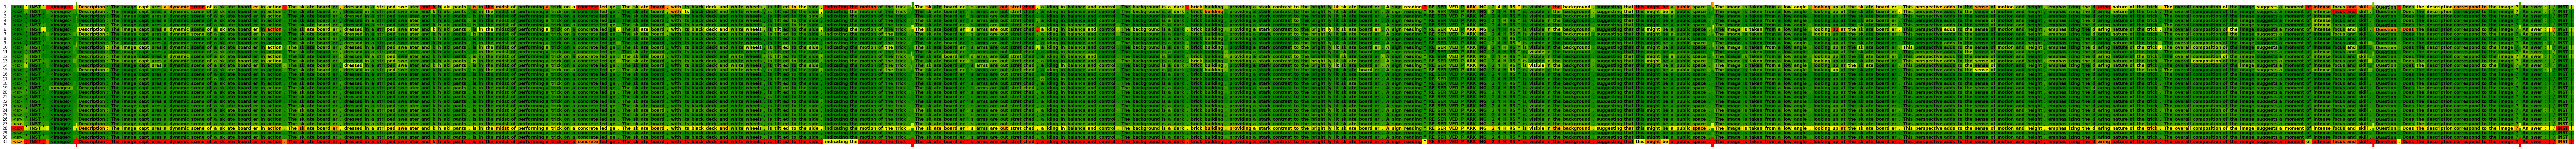

In [7]:
# Visualize tokenwise linearity for LLaVA-NeXT applied to the first example
buf, log_info = mllm_microscope.visualize_tokenwise_linearity(model_name=model_names[0], saving_path="./tokenwise_linearity")
print(log_info)

In [8]:
# Obtain intermediate embeddings for OmniFusion
omnifusion_embs = mllm_microscope.get_intermediate_embeddings(model_name=model_names[1], texts=texts, images=images, max_tokens=MAX_TOKENS)

Initializing the OmniFusion model...


Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

OmniFusion Model Architecture:
MistralForCausalLM(
  (model): MistralModel(
    (embed_tokens): Embedding(32000, 4096)
    (layers): ModuleList(
      (0-31): 32 x MistralDecoderLayer(
        (self_attn): MistralSdpaAttention(
          (q_proj): Linear(in_features=4096, out_features=4096, bias=False)
          (k_proj): Linear(in_features=4096, out_features=1024, bias=False)
          (v_proj): Linear(in_features=4096, out_features=1024, bias=False)
          (o_proj): Linear(in_features=4096, out_features=4096, bias=False)
          (rotary_emb): MistralRotaryEmbedding()
        )
        (mlp): MistralMLP(
          (gate_proj): Linear(in_features=4096, out_features=14336, bias=False)
          (up_proj): Linear(in_features=4096, out_features=14336, bias=False)
          (down_proj): Linear(in_features=14336, out_features=4096, bias=False)
          (act_fn): SiLU()
        )
        (input_layernorm): MistralRMSNorm()
        (post_attention_layernorm): MistralRMSNorm()
      )
  

/home/ra.mussabayev/AIRI/mllm_microscope.py:416: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.omnifusion_projection = torch.load("OmniMistral-v1_1/projection.pt", map_

Computing the intermediate embeddings for the OmniFusion model...


  0%|          | 0/64 [00:00<?, ?it/s]

<image>
Description: The image captures a dynamic scene of a skateboarder in action. The skateboarder, dressed in a striped sweater and khaki pants, is in the midst of performing a trick on a concrete ledge. The skateboard, with its black deck and white wheels, is tilted to the side, indicating the motion of the trick.

The skateboarder's arms are outstretched, aiding in balance and control. The background is a dark, brick building, providing a stark contrast to the brightly lit skateboarder. A sign reading "RESERVED PARKING 24 HRS" is visible in the background, suggesting that this might be a public space.

The image is taken from a low angle, looking up at the skateboarder. This perspective adds to the sense of motion and height, emphasizing the daring nature of the trick. The overall composition of the image suggests a moment of intense focus and skill.
Question: Does the description correspond to the image?
Answer:


  2%|▏         | 1/64 [00:01<01:13,  1.16s/it]

<image>
Description: The image captures a dynamic moment in a baseball game. The central figures are the batter, the catcher, and the umpire. 

The batter, dressed in a crisp white uniform with the number 2 emblazoned on it, is in the midst of a powerful swing. His stance is one of concentration and strength, as he prepares to hit the incoming pitch.

Behind him, the catcher is crouched in anticipation. He's clad in a blue uniform with the number 41, ready to catch the ball if the batter misses. His position is one of readiness, his eyes focused on the incoming pitch.

The umpire, standing just behind the catcher, is dressed in a black uniform. He's attentively observing the play, ready to make a call. His position gives him a clear view of both the batter and the catcher, allowing him to make accurate judgments.

The scene is set against the backdrop of a well-maintained baseball field. The dirt infield is clearly visible, with the home plate and the batter's box marked out. The grass

  3%|▎         | 2/64 [00:02<01:03,  1.02s/it]

<image>
Description: The image captures a cozy dining scene. At the center of the frame is a table, draped with a red and white checkered tablecloth. The table is set for two, with two plates of food and two glasses of red wine.

On the left side of the table, there's a plate of food that includes a serving of rice, a portion of black beans, and a piece of meat. The rice appears to be well-cooked, the black beans are dark and possibly seasoned, and the meat is browned, suggesting it might be grilled or roasted.

On the right side of the table, there's another plate of food. This one includes a serving of rice, a portion of black beans, and a piece of meat. The rice, beans, and meat are similar to the ones on the left plate, indicating that the meal is likely shared.

In front of each plate, there's a glass of red wine. The wine glasses are clear, allowing the rich red color of the wine to be visible. The glasses are filled to about half their capacity, suggesting that the meal is in pr

  5%|▍         | 3/64 [00:05<02:19,  2.29s/it]

<image>
Description: The image depicts a cozy tea setting on a wooden table. In the center, there's a white teapot with gold accents, adorned with a floral pattern. To the left of the teapot, there's a teacup with a matching saucer, both featuring a blue and white color scheme with a floral design.

On the right side of the teapot, there's a wooden cutting board with a handle, serving as a serving tray. On this board, there are two golden-brown biscuits, which appear to be freshly baked. Accompanying the biscuits are three small white bowls filled with different condiments one with a red jam, one with a yellow butter, and one with a brown sauce.

In the background, there's a white wall with horizontal paneling, and a wooden chair is partially visible on the left side of the image. The overall setting suggests a warm and inviting atmosphere, likely in a home or a small café.
Question: Does the description correspond to the image?
Answer:


  6%|▋         | 4/64 [00:06<01:39,  1.65s/it]

<image>
Description: The image shows a wooden cutting board with various chopped vegetables and a whole broccoli floret. On the left side of the board, there are sliced red bell peppers, and in the center, there are chopped onions. To the right, there are sliced yellow bell peppers. A whole broccoli floret is placed on the right side of the board. A knife with a black handle is resting on the board, suggesting it was used for chopping the vegetables. In the background, there is a glimpse of a kitchen counter with a red lidded container and a white appliance, possibly a refrigerator. The image captures a moment in the process of food preparation, with the focus on the fresh ingredients and the knife used for cutting.
Question: Does the description correspond to the image?
Answer:


  8%|▊         | 5/64 [00:07<01:13,  1.25s/it]

<image>
Description: In the image, a young man is captured in the midst of a daring skateboard trick on a vibrant, mosaic-tiled bench. The bench, adorned with a riot of colors, serves as a striking backdrop to the scene. The skateboarder, dressed in a casual ensemble of a white t-shirt and black pants, is skillfully balancing on the edge of the bench with his skateboard. His body leans forward, indicating the momentum of his movement. The skateboard, under his control, is positioned on the right side of the bench, ready to spring back into action.

The setting appears to be an urban park or a similar public space, characterized by a concrete ground and a wall in the background. The wall is not just any wall, but a canvas for street artists, adorned with colorful graffiti that adds to the overall vibrancy of the scene. The graffiti includes various elements such as stars, buildings, and text, creating a dynamic and lively atmosphere.

The image beautifully captures a moment of action an

  9%|▉         | 6/64 [00:07<00:59,  1.03s/it]

<image>
Description: The image depicts a tranquil rural scene. A group of **six sheep**, their coats a mix of white and black, are huddled together in the foreground. They are standing on a bed of straw, which is scattered around them, suggesting a comfortable resting area.

The sheep are enclosed within a **wooden fence**, which is topped with a strand of barbed wire, indicating a secure boundary. The fence is made of wooden posts and wire, providing a rustic charm to the scene.

In the background, there's a **tree** with bare branches, hinting at a colder season. The tree stands tall, its silhouette contrasting with the low-lying sheep.

The sky above is a clear **blue**, suggesting a bright and sunny day. The overall scene is peaceful and idyllic, capturing a moment of calm in the countryside.
Question: Does the description correspond to the image?
Answer:


 11%|█         | 7/64 [00:08<00:52,  1.08it/s]

<image>
Description: The image shows a large truck with a trailer designed to transport livestock. The trailer is divided into multiple compartments, each with a white metal fence structure that appears to be designed to secure the animals. The truck is predominantly white with blue trim along the bottom of the trailer. The cab of the truck is visible on the right side of the image, and it is a light color, possibly beige or light gray.

The trailer is filled with a large number of animals, which appear to be sheep or goats, based on their size and the shape of their heads. The animals are densely packed, with some standing and others lying down. They have a light-colored wool or fur, and their heads are visible through the gaps in the fencing.

The truck is parked, and there is no visible text or branding on the vehicle that would indicate the company or the origin of the truck. The background is nondescript, with a clear sky and no other objects or landmarks that provide context abou

 12%|█▎        | 8/64 [00:09<00:48,  1.15it/s]

<image>
Description: The image shows a pizza in the process of being cooked. The pizza has a golden-brown crust with a slightly darker edge, indicating it's been baked. The toppings include what appears to be thinly sliced ham or prosciutto, chunks of white cheese that could be mozzarella, and green herbs that might be basil or a similar leafy vegetable. The pizza is placed on a metal surface, which could be a pizza peel or a pan, and it's positioned in front of a brick oven with visible heating elements above it. The oven interior is dark, and the light is focused on the pizza, highlighting its details. The image has a warm, inviting tone, suggesting a cozy and appetizing atmosphere.
Question: Does the description correspond to the image?
Answer:


 14%|█▍        | 9/64 [00:11<01:14,  1.35s/it]

<image>
Description: In the image, a baby is peacefully sleeping on a white pillow. The baby is dressed in a white onesie adorned with yellow flowers. The baby is comfortably nestled under a pink blanket, which adds a soft contrast to the white pillow.

On either side of the baby, there are two brown teddy bears. The teddy bear on the left is holding a red bottle of Dr. Pepper, while the teddy bear on the right is holding a red bottle of Dr. Pepper. The teddy bears seem to be guardians of the sleeping baby, providing a sense of comfort and security.

The entire scene is set against a beige couch, which provides a neutral backdrop that allows the colors in the image to stand out. The overall atmosphere of the image is one of tranquility and warmth, with the sleeping baby as the centerpiece.
Question: Does the description correspond to the image?
Answer:


 16%|█▌        | 10/64 [00:12<01:00,  1.12s/it]

<image>
Description: In the image, there are two men standing on a concrete surface. The man on the left is seated on a green motorcycle with a yellow and black number "K57" on the front. He is wearing a black leather jacket and a pair of black boots. His arms are crossed, and he is smiling at the camera.

Standing next to him is another man who is wearing a beige jacket and blue jeans. He is also smiling and looking at the camera.

In the background, there is a red and white striped pole and a blue sign with a white arrow pointing to the left. The sky is cloudy, suggesting it might be a cool or overcast day.

The motorcycle has a black seat and a silver exhaust pipe. The number "168" is also visible on the front of the motorcycle. The overall scene suggests that these two men might be preparing for a ride or have just finished one.
Question: Does the description correspond to the image?
Answer:


 17%|█▋        | 11/64 [00:14<01:15,  1.43s/it]

<image>
Description: The image shows an interior view of a hotel room, focusing on the bed area. The bed is large and appears to be a king-size with a white bedspread and a red bed runner at the foot. There are two white pillows at the head of the bed. The room has a modern design with a dark brown accent wall behind the bed, which contrasts with the lighter colors of the bed linens and the white wall to the left.

On the left side of the bed, there is a nightstand with a lamp that has a pink shade, casting a warm glow on the wall. Above the nightstand, there is a decorative piece of wall art with a floral pattern. The room is well-lit, with a combination of natural light coming through the window, which is covered with red curtains, and artificial light from the lamp.

The overall ambiance of the room is cozy and inviting, with a color scheme that includes shades of red, white, and brown. The room is clean and well-maintained, suggesting it is ready for guests. There are no visible te

 19%|█▉        | 12/64 [00:15<01:06,  1.27s/it]

<image>
Description: The image depicts a serene harbor scene. In the foreground, there's a **blue and white boat** with the registration number **1098225**. The boat is docked at a pier, and there's a person standing on the deck, possibly overseeing the boat or preparing for a journey.

In the background, there are several other boats of various sizes and colors, all docked and bobbing gently on the water. The harbor is nestled amidst lush green trees and buildings, adding a touch of urban life to the otherwise natural landscape.

The sky above is a clear blue, suggesting a bright and sunny day. The calm water reflects the colors of the boats and the surrounding environment, creating a beautiful and peaceful atmosphere.

Overall, the image captures a moment of tranquility in a bustling harbor, with the boats waiting patiently for their next voyage.
Question: Does the description correspond to the image?
Answer:


 20%|██        | 13/64 [00:15<00:53,  1.05s/it]

<image>
Description: The image shows a close-up of a cat with striking blue eyes. The cat has a coat that appears to be a mix of white and dark brown or black, with the dark color concentrated around the ears, face, and tail. The cat's eyes are wide open, and its gaze is directed towards something outside the frame, giving it a focused and attentive expression. The cat's whiskers are clearly visible, and its ears are perked up, suggesting alertness. The background is blurred, which puts the emphasis on the cat's face. The lighting in the photo is soft, with no harsh shadows, which highlights the cat's fur texture and the color of its eyes.
Question: Does the description correspond to the image?
Answer:


 22%|██▏       | 14/64 [00:16<00:48,  1.04it/s]

<image>
Description: The image shows two different species of animals in a natural setting. In the foreground, there is a large bird with a long neck and a distinctive head shape, which appears to be an ostrich. The ostrich is facing the camera, and its feathers are a light color, possibly white or cream.

In the background, there is a giraffe, which is characterized by its long neck and legs, and its distinctive spotted coat pattern. The giraffe is facing to the left of the frame, and its head is turned slightly towards the camera. The giraffe's coat is a mix of brown and white patches.

Both animals are standing in a wooded area with trees and foliage in the background. The lighting suggests it might be daytime, and the overall atmosphere of the image is serene and natural. There are no visible texts or distinguishing marks that provide additional context about the location or the circumstances under which the photo was taken.
Question: Does the description correspond to the image?
A

 23%|██▎       | 15/64 [00:17<00:41,  1.17it/s]

<image>
Description: In the image, a man is seen standing on a sidewalk, waving his hand towards a yellow school bus that is parked on the street. The bus is large and yellow, with its doors closed. The man is dressed in a blue jacket and is standing next to a bicycle that is leaning against a brick wall. The bicycle has a black seat and handlebars.

The scene is set in a suburban neighborhood, with houses visible in the background. The sky above is overcast, suggesting that it might be a cloudy day. The man's action of waving towards the bus could indicate that he is either greeting someone on the bus or signaling to the bus driver. The overall atmosphere of the image is calm and peaceful, typical of a quiet neighborhood.
Question: Does the description correspond to the image?
Answer:


 25%|██▌       | 16/64 [00:19<01:02,  1.30s/it]

<image>
Description: In the image, a person is skateboarding down a steep, curving road. The skateboarder is wearing a black helmet and a black shirt, and they are crouched low on their skateboard, which is black as well. The road is paved and appears to be in good condition, with a yellow line running down the middle.

On the left side of the road, there is a fence made of metal poles and wire. The fence is topped with barbed wire, suggesting that it might be a security fence. On the right side of the road, there is a grassy area with trees and bushes.

In the background, there are buildings that appear to be industrial or commercial in nature. The sky is clear and blue, indicating that it is a sunny day. The overall scene suggests that the skateboarder is enjoying a sunny day outdoors, taking advantage of the empty road to practice their skateboarding skills.
Question: Does the description correspond to the image?
Answer:


 27%|██▋       | 17/64 [00:19<00:48,  1.03s/it]

<image>
Description: In the image, there are two individuals seated on a vibrant red couch adorned with a pattern of white flowers. The person on the left is holding a laptop that is covered in a variety of colorful stickers, including one that reads "Free" and another that says "Fire Eagle". The individual on the right is also holding a laptop, which is similarly decorated with stickers, including one that reads "CC". Both individuals are smiling, suggesting a positive and friendly atmosphere. The background is blurred, but it appears to be a room with a red wall and a window, adding to the overall warm and inviting ambiance of the scene.
Question: Does the description correspond to the image?
Answer:


 28%|██▊       | 18/64 [00:20<00:38,  1.20it/s]

<image>
Description: The image shows a blender with a clear pitcher that is filled with a green liquid, possibly a smoothie or juice. The blender is placed on a wooden surface, and it is plugged into an electrical outlet on a brick wall. The blender has a white base with a control panel that includes buttons and a digital display. The lid of the blender is missing, and it appears to be taped over with gray duct tape, suggesting that the blender may be damaged or in need of repair. The overall setting suggests a casual, possibly domestic environment.
Question: Does the description correspond to the image?
Answer:


 30%|██▉       | 19/64 [00:20<00:31,  1.44it/s]

<image>
Description: In the heart of a bustling city, a daring skateboarder takes flight, soaring over a series of white cones that mark his path. The skateboarder, dressed in a casual ensemble of a t-shirt and jeans, is captured mid-air, his body suspended above the skateboard as he executes a daring trick. His arms are outstretched, aiding his balance as he defies gravity.

The scene unfolds on a street that has been transformed into a makeshift skate park. The white cones, scattered haphazardly, serve as obstacles for the skateboarder to navigate. They stand out starkly against the backdrop of the city, drawing attention to the spectacle unfolding before them.

In the background, a group of spectators watches the spectacle unfold. Their faces are a mix of awe and anticipation, their eyes following the skateboarder's every move. Their presence adds a sense of community and camaraderie to the scene, turning it into more than just a display of skill - it's a shared moment of excitement

 31%|███▏      | 20/64 [00:22<00:48,  1.10s/it]

<image>
Description: In the image, an older man is engrossed in the art of kite making. He is standing at a table, which is covered with a variety of materials and tools. The man is wearing a black shirt and glasses, and he appears to be in the process of folding a pink kite.

The table is a hub of activity, with several kites in various stages of completion. There are also scissors and a ruler, essential tools for precise measurements and cutting. A sewing machine is also present, indicating that some parts of the kites might be sewn together.

The room around the table is filled with books, suggesting that the man might be following a specific pattern or design for his kites. The walls are adorned with paintings, adding a touch of creativity to the space.

In the background, there's a couch and a chair, providing a comfortable seating area. The overall atmosphere of the room is one of creativity and craftsmanship.
Question: Does the description correspond to the image?
Answer:


 33%|███▎      | 21/64 [00:23<00:39,  1.08it/s]

<image>
Description: The image shows two open suitcases placed side by side on a floor. The left suitcase is larger and appears to be filled with various items, including what looks like clothing and possibly some personal belongings. The right suitcase is smaller and contains a white laptop on top, with some papers or documents underneath. To the right of the suitcases, there is a small, colorful toy with a smiling face, which seems to be a character from a children's show or book. The toy has a yellow body, a red hat, and a red and yellow striped shirt. The background is a plain, light-colored wall, and the floor is tiled. There are no visible texts or distinctive brands in the image. The style of the image is a straightforward, candid photograph with no artistic filters or effects applied.
Question: Does the description correspond to the image?
Answer:


 34%|███▍      | 22/64 [00:23<00:34,  1.24it/s]

<image>
Description: The image shows a stop sign with the word "BUSH" added below the word "STOP" in a bold, capitalized font. The stop sign is red with white lettering and is mounted on a metal pole. The sign has been vandalized with graffiti, as indicated by the word "BUSH" and additional scribbles in white paint. The background of the image features a street scene with a red car parked on the side of the road, and there are trees and a building visible in the distance. The sky is partly cloudy, suggesting it might be a sunny day. The overall style of the image is a candid, real-life photograph with no apparent artistic filters or effects applied.
Question: Does the description correspond to the image?
Answer:


 36%|███▌      | 23/64 [00:24<00:29,  1.38it/s]

<image>
Description: In the image, a young girl is the main subject, standing in the foreground on a lush green lawn. She is dressed in a white tank top and blue plaid shorts, and she has blonde hair. The girl is looking up at a yellow frisbee that is in mid-air, suggesting she might be playing with it.

Behind the girl, there is a large, gray stone house with a prominent turret. The house has multiple windows and a gray roof, giving it a grand and imposing appearance. The house is surrounded by a well-maintained lawn, which extends to the foreground where the girl is standing.

The sky above is overcast, casting a soft light over the scene. The overall atmosphere of the image is peaceful and serene, with the girl's activity adding a touch of liveliness to the otherwise tranquil setting.
Question: Does the description correspond to the image?
Answer:


 38%|███▊      | 24/64 [00:24<00:26,  1.50it/s]

<image>
Description: The image depicts a snowy landscape with a person engaged in winter sports. The person appears to be snowboarding, as they are standing on a snowboard and are positioned in a stance that suggests they are either preparing to descend a slope or have just completed a run. They are wearing dark clothing, which contrasts with the white snow, and their body is angled slightly to the side, indicating movement or preparation for movement.

The background features a series of snow-covered slopes and hills, with trees scattered across the landscape. The trees are also covered in snow, suggesting recent snowfall or a well-preserved snowpack. The sky is overcast, with no visible blue sky, which contributes to the wintry atmosphere of the scene.

The image is taken from a distance, capturing the person and the surrounding environment in a single frame. The focus is on the person and their immediate surroundings, with the background slightly blurred, which helps to draw attenti

 39%|███▉      | 25/64 [00:27<00:47,  1.21s/it]

<image>
Description: The image captures a lively street scene in a city. The street is bustling with people, some of whom are walking, while others are standing, possibly waiting or just enjoying the atmosphere. The buildings lining the street are a mix of brick and stone, with a variety of architectural styles, suggesting a rich history.

On the left side of the street, there's a blue building with a sign that reads "Wesport". This could be a shop or a business establishment. Further down the street, there's a green building with a sign that reads "Strad Grafton Street". This might be another shop or business.

The street is adorned with several street signs, including one that reads "Bara on Temple Bar" and another that reads "The Environmental Information Service". These signs provide directions and information to the pedestrians.

The sky above is clear, suggesting a sunny day. The overall scene is vibrant and full of life, typical of a busy city street.
Question: Does the descript

 41%|████      | 26/64 [00:27<00:36,  1.03it/s]

<image>
Description: The image depicts a group of people walking on a cobblestone street during what appears to be a rainy day. In the foreground, there are three individuals who are more prominently featured. The person on the left is wearing a black jacket, blue jeans, and brown boots, and is carrying a colorful bag. The individual in the center is holding a pink umbrella and is wearing a black jacket, black pants, and black boots. The person on the right is also holding an umbrella, which is black, and is wearing a black jacket, a patterned scarf, blue jeans, and black boots.

In the background, there are several other people walking, some of whom are also holding umbrellas. The architecture suggests a European setting, possibly Paris, given the style of the buildings and the cobblestone street. The sky is overcast, and the ground is wet, indicating recent or ongoing rain. The overall atmosphere of the image is one of a typical rainy day in a city.
Question: Does the description cor

 42%|████▏     | 27/64 [00:28<00:34,  1.09it/s]

<image>
Description: In the image, there are two black and white dogs peacefully sleeping in a green pet bed. The bed is lined with a white cushion, providing a soft and comfortable surface for the dogs. The dog on the left is curled up in a ball, its head resting on its paws, while the dog on the right is lying on its side, its head resting on the cushion. 

Scattered around the bed are three stuffed animals, adding a playful touch to the scene. There's a red stuffed animal on the left, a purple one in the middle, and a pink one on the right. The dogs seem to be in a deep sleep, undisturbed by their surroundings. The image captures a moment of tranquility and comfort for these two pets.
Question: Does the description correspond to the image?
Answer:


 44%|████▍     | 28/64 [00:31<00:51,  1.44s/it]

<image>
Description: The image is a captivating representation of an impressionist still life painting. The scene is set on a table draped with a pristine white tablecloth. The table hosts a variety of objects, each contributing to the overall composition.

On the left side of the table, there's a vibrant red shell, its color contrasting beautifully with the white tablecloth. Next to it, a white coffee cup with a black handle adds a touch of elegance. A yellow lemon, its bright hue adding a pop of color, is also present on the table.

On the right side of the table, a black clock with a white face stands out against the lighter tones of the other objects. The clock's presence adds a sense of time to the scene.

In the background, a black vase with a white handle can be seen. Its dark color provides a nice contrast to the lighter objects in the foreground.

The painting is executed in an impressionist style, characterized by loose brushstrokes and a focus on the interplay of light and s

 45%|████▌     | 29/64 [00:31<00:43,  1.26s/it]

<image>
Description: The image depicts an indoor scene, likely a fruit and vegetable stall or market stand. In the foreground, there is a person with dark hair, wearing a striped shirt, who appears to be a customer or possibly a vendor. The person is facing away from the camera, looking towards the fruit display.

The fruit display is abundant and colorful, with a variety of produce. There are several bunches of ripe bananas hanging from a metal rod, which spans the width of the image. Below the bananas, there are shelves stocked with various packaged goods, including what looks like canned items and possibly some snacks or beverages.

In the foreground, there are boxes of apples, with the visible ones being red and green, suggesting they are fresh and possibly for sale. The apples are neatly arranged in boxes, and there is a price tag visible, indicating that they are for sale.

The lighting in the image is bright, suggesting an indoor environment with artificial lighting. The overall

 47%|████▋     | 30/64 [00:33<00:49,  1.45s/it]

<image>
Description: The image shows a cake designed to resemble a black top hat and a white glove, which are iconic symbols associated with the character of Michael Jackson. The cake is placed on a red plate with white stars around the edge. The hat is positioned on top of the plate, and the glove is placed to the side. The cake is decorated with white icing to mimic the appearance of the hat and glove.

On the hat, there is a message written in white icing that reads "Happy 55th Birthday MICHAEL." The text is arranged in a way that the word "Happy" is at the top, "55th" is in the middle, and "Birthday MICHAEL" is at the bottom. The stars on the plate are also made of white icing.

The background of the image is a tablecloth with a floral pattern, and there is a glass with a yellowish liquid in the top left corner of the image. The overall style of the image is a close-up photograph with a focus on the cake, capturing the details of the decoration and the message.
Question: Does the d

 48%|████▊     | 31/64 [00:34<00:37,  1.15s/it]

<image>
Description: In the image, a person is standing in a grassy field, their body angled towards the right side of the frame. They are dressed in a blue shirt and brown pants, and are holding a black and white kite string in their right hand. The kite, which is black and white, is soaring high in the sky, positioned in the top right corner of the image. The person's gaze is directed upwards, following the path of the kite. In the background, there are trees and buildings, adding depth to the scene. The sky above is filled with clouds, suggesting an overcast day. The overall scene captures a moment of leisure and enjoyment of outdoor activities.
Question: Does the description correspond to the image?
Answer:


 50%|█████     | 32/64 [00:34<00:29,  1.09it/s]

<image>
Description: The image depicts an urban landscape with a focus on transportation infrastructure. In the foreground, there is a train on a track, with a green and yellow passenger car and a black locomotive. The train is stationary, and the tracks appear to be part of a larger network.

In the middle ground, there is a large construction site with a yellow crane, indicating ongoing development. The site is surrounded by a fence, and there are several construction materials visible, including what appears to be scaffolding and building components.

The background features a mix of buildings, including a prominent yellow building with many windows, which could be an apartment complex or commercial building. There are also other structures, some with red roofs, suggesting a variety of architectural styles and purposes.

A red bridge spans over the train tracks, connecting different parts of the city. The bridge has a distinctive red color and a sturdy appearance, likely designed to

 52%|█████▏    | 33/64 [00:35<00:26,  1.16it/s]

<image>
Description: The image shows a computer desk with two monitors side by side. The left monitor displays a desktop with various icons and a wallpaper that includes multiple photographs of birds and nature scenes. The right monitor shows a web browser with a webpage open, displaying a list of items or data.

On the desk, there is a black keyboard in front of the monitors, and to the right of the keyboard, there is a black mouse. To the left of the keyboard, there is a black stapler. In the center of the desk, there is a black mug with a yellow lid, and to the right of the mug, there is a small yellow box with a black label.

The desk appears to be in an office environment, as suggested by the presence of the monitors, keyboard, and mouse, which are typical office equipment. The desk is cluttered with various items, indicating that it is actively used. The image is a photograph and captures the scene from a slightly elevated angle, providing a clear view of the desk and its content

 53%|█████▎    | 34/64 [00:35<00:23,  1.29it/s]

<image>
Description: In the image, a man is captured in the midst of a delightful culinary experience. He's seated at a table, his attention fully absorbed by the glazed donut he's about to take a bite of. His eyes are closed, perhaps in anticipation of the sweet treat, and his mouth is open wide, ready to savor the moment.

The man is dressed in a black jacket, which contrasts with the white shirt he's wearing underneath. His glasses add a touch of sophistication to his appearance. The table in front of him is adorned with a white tablecloth, providing a clean and simple backdrop for the scene.

The setting appears to be a restaurant or cafe, as suggested by the blurred background. The focus is solely on the man and his donut, making it the centerpiece of this image. The overall composition of the photo suggests a moment of simple pleasure, frozen in time.
Question: Does the description correspond to the image?
Answer:


 55%|█████▍    | 35/64 [00:37<00:24,  1.16it/s]

<image>
Description: In the heart of the image, a white teddy bear with pink ears and a pink snout is the star of the scene. The teddy bear, adorned with a pink bow around its neck, is comfortably seated on a beige carpeted floor. It's engrossed in a yellow book that it holds in its paws, suggesting a love for reading.

The teddy bear is positioned in front of a wooden chair, which adds a touch of rustic charm to the scene. The chair is situated on a blue and white patterned rug, adding a splash of color to the otherwise neutral tones of the room.

The teddy bear's position on the floor and its engagement with the book create an atmosphere of quiet contemplation and learning. It's as if the teddy bear is inviting us to join it in its cozy corner of the room, to pick up a book and lose ourselves in its pages.
Question: Does the description correspond to the image?
Answer:


 56%|█████▋    | 36/64 [00:38<00:30,  1.09s/it]

<image>
Description: The image shows a motorcycle parked on a sandy terrain with grass and shrubs in the background. The motorcycle is a black and silver color, with a visible license plate that reads "755022". The bike is equipped with a large blue saddlebag on the back, suggesting it is designed for long rides or touring. The handlebars are equipped with rearview mirrors and there is a small screen or fairing in front of the handlebars, which is typical for motorcycles designed for better aerodynamics and rider comfort. The motorcycle also has a visible exhaust pipe on the right side. The tires appear to be off-road or dual-sport type, with deep treads for better grip on various surfaces. The overall style of the image is a natural, outdoor setting with a focus on the motorcycle, which is the main subject of the photograph.
Question: Does the description correspond to the image?
Answer:


 58%|█████▊    | 37/64 [00:39<00:23,  1.15it/s]

<image>
Description: The image shows a male tennis player in a white outfit, which includes a polo shirt and shorts, standing on a tennis court. He is holding a tennis racket with both hands, ready to play. The player is wearing a white cap and has a focused expression on his face, suggesting he is concentrating on the game. In the background, there are other individuals, likely spectators or officials, but they are not the main focus of the image. The setting appears to be an outdoor tennis court, as indicated by the green surface and the presence of a crowd. The style of the image is a candid photograph, capturing a moment during a tennis match.
Question: Does the description correspond to the image?
Answer:


 59%|█████▉    | 38/64 [00:40<00:28,  1.11s/it]

<image>
Description: The image shows a neatly arranged hotel room with a large bed as the central focus. The bed has a beige headboard and is dressed with a white bedspread that has a subtle gray stripe pattern. There are multiple pillows on the bed, including two larger ones at the head and two smaller ones at the foot, all covered in white pillowcases. A gray throw blanket is folded at the foot of the bed, adding a touch of color to the otherwise neutral palette.

On either side of the bed, there are nightstands with lamps that have yellow shades, providing a warm glow to the room. The lamps are turned on, illuminating the space. The room has a carpeted floor, and there is a window with sheer curtains to the left, allowing natural light to filter into the room. The overall ambiance of the room is calm and inviting, typical of a hotel setting designed for comfort and relaxation.
Question: Does the description correspond to the image?
Answer:


 61%|██████    | 39/64 [00:41<00:26,  1.05s/it]

<image>
Description: The image depicts a modern bathroom interior. The bathroom features a dark color scheme with black marble or similar dark-toned countertops. On the countertop, there is a white oval-shaped sink with a silver faucet. To the right of the sink, there are various toiletries including a bottle of water, a green soap dispenser, and a white box that could be a tissue box or a small toiletry item. A white towel is neatly folded and placed on the countertop.

In the background, there is a bathtub with a pinkish hue, suggesting it might be a light-colored or possibly a pink bathtub. Above the bathtub, there is a mirror that reflects the interior of the bathroom, including the door and the wall. The door has a gold-colored handle and appears to be closed. The wall is adorned with dark-colored tiles that match the countertop.

The lighting in the bathroom is soft and ambient, creating a calm and luxurious atmosphere. The overall style of the bathroom suggests a contemporary de

 62%|██████▎   | 40/64 [00:42<00:21,  1.09it/s]

<image>
Description: In the image, a tranquil scene unfolds in a bedroom bathed in soft light. A woman, dressed in a black shirt, is comfortably nestled on a bed adorned with a vibrant quilt in hues of pink and purple. Her eyes are gently closed, suggesting a moment of rest or perhaps a brief nap.

The bed is not just a resting place for the woman, but also for her feline companions. Three cats, each with their own unique fur patterns, are scattered across the bed. One cat is perched on the woman's chest, perhaps seeking warmth or companionship. Another cat is lying on the bed near the woman's feet, while the third cat is resting on the quilt, close to the woman's side.

The room itself is simple yet cozy. A nightstand stands guard next to the bed, hosting a lamp that casts a warm glow across the room. The walls are painted in a soothing shade of green, adding to the overall calm and peaceful atmosphere of the scene.

Every object in this image, from the woman and her cats to the furni

 64%|██████▍   | 41/64 [00:42<00:18,  1.25it/s]

<image>
Description: The image captures a serene cityscape viewed from a high vantage point. Dominating the scene is a majestic clock tower, its gray spire reaching towards the sky. The tower is adorned with a gold weather vane at its peak, gleaming under the sunlight. Two clock faces, one on each side of the tower, display the time, their golden numbers and hands standing out against the gray stone.

The city below is a patchwork of red rooftops, interspersed with green trees that add a touch of nature to the urban landscape. The buildings, varying in height and design, create a sense of depth and scale. The perspective of the photo suggests it was taken from a nearby building, offering a bird's eye view of the city.

In the foreground, a black bird with a white chest is perched on a ledge, adding a touch of life to the scene. Its presence adds a sense of scale, emphasizing the grandeur of the clock tower and the cityscape beyond.

Overall, the image beautifully juxtaposes the stillne

 66%|██████▌   | 42/64 [00:43<00:17,  1.26it/s]

<image>
Description: The image shows a person playing tennis on a court. The individual is wearing a white polo shirt with a logo on the left chest, blue shorts with a number "11" on the left leg, and white tennis shoes with blue accents. They are holding a tennis racket in their right hand and appear to be in the middle of a swing, possibly returning a serve or hitting a ball. The person has short hair and is looking to the left side of the frame, which suggests they are focused on the ball or their opponent.

The tennis court has a green surface with white boundary lines, and there is a chain-link fence in the background, which is typical for outdoor tennis courts. The sky is clear, indicating good weather conditions for playing tennis. There is another person visible in the background, but they are not the main focus of the image. The style of the image is a candid, real-life photograph capturing an active moment during a tennis match.
Question: Does the description correspond to th

 67%|██████▋   | 43/64 [00:44<00:15,  1.37it/s]

<image>
Description: The image shows a close-up of a broccoli plant in its natural environment. The broccoli florets are in various stages of growth, with some appearing more mature and others still in the early stages of development. The florets are a vibrant green color, indicating freshness and good health. The plant's leaves are a deep purple-green hue, which is characteristic of certain varieties of broccoli. The background is slightly blurred, but it appears to be a garden or a field with other plants, suggesting that the broccoli is growing in an outdoor setting. The overall image has a naturalistic feel, capturing the plant in its habitat.
Question: Does the description correspond to the image?
Answer:


 69%|██████▉   | 44/64 [00:46<00:25,  1.25s/it]

<image>
Description: The image depicts a scene at a bus stop. A group of people are waiting to board a bus. The bus is a blue and white color, and it is parked at the curb. The people are standing on the sidewalk, and they are carrying various items such as backpacks and handbags. The bus stop is located under a bridge, and there are signs visible in the background. The sky is overcast, suggesting that it might be a cloudy day. The people appear to be waiting patiently for the bus to open its doors.
Question: Does the description correspond to the image?
Answer:


 70%|███████   | 45/64 [00:46<00:18,  1.02it/s]

<image>
Description: The image shows a close-up of a wooden surface with various food items and kitchenware. In the foreground, there is a glass bowl containing a creamy, pale yellow substance that could be a type of sauce or spread. A spoon with a dollop of the same substance is resting on the bowl's rim. To the left of the bowl, there is a halved grapefruit with its juicy, pink flesh exposed, and a whole orange is partially visible in the background. The background also includes another glass bowl that appears to contain a clear liquid, possibly a juice or a broth. The overall setting suggests a preparation for a meal or a snack, with a focus on citrus fruits and a creamy accompaniment. The lighting in the image is soft and warm, highlighting the textures and colors of the food and the wooden surface.
Question: Does the description correspond to the image?
Answer:


 72%|███████▏  | 46/64 [00:49<00:23,  1.32s/it]

<image>
Description: The image shows a homemade stop sign made from a wooden block. The block is painted yellow and has a red octagonal shape with the word "STOP" written in white capital letters. The sign is attached to a wooden post, which is also painted yellow. The post is standing upright on a surface that appears to be a table or a countertop. In the background, there is a blurred view of a forest with trees that have autumn foliage, suggesting the photo was taken during the fall season. The focus of the image is on the stop sign, with the background being out of focus to emphasize the sign. The overall style of the image is casual and appears to be a personal photograph rather than a professional one.
Question: Does the description correspond to the image?
Answer:


 73%|███████▎  | 47/64 [00:49<00:17,  1.03s/it]

<image>
Description: The image depicts a scene at what appears to be a food market or fair. In the foreground, there is a person wearing a blue shirt, partially visible, with a blue strap over their shoulder, possibly from a bag or a camera. The person is looking towards the right side of the image, where a large stack of chocolate brownies is displayed. The brownies are stacked in a pyramid shape, with the largest at the bottom and the smallest at the top, creating a visually appealing presentation.

The brownies are dark brown in color, suggesting they are rich and possibly moist. They are placed on a table with a green and white checkered tablecloth, which adds a rustic or picnic-like feel to the setting. In front of the brownies, there are two smaller trays with what looks like chocolate crumbs or cookie crumbles, possibly for sampling or as a garnish.

In the background, there are other people, some of whom are engaged in conversation or looking at the food items. The setting incl

 75%|███████▌  | 48/64 [00:49<00:13,  1.19it/s]

<image>
Description: The image shows a train traveling on a railway track. The train consists of multiple blue passenger cars with white doors and windows, and a red locomotive at the front. The locomotive is pulling the passenger cars along the track, which is set against a backdrop of a clear sky and a lush green hillside. The railway track is bordered by a grassy area on the left side and a fence on the right side. There is a small structure, possibly a signal box or a small building, near the track. The overall scene suggests a rural or semi-rural setting, with the train providing a mode of transportation through the landscape. The image is taken during the daytime under bright sunlight.
Question: Does the description correspond to the image?
Answer:


 77%|███████▋  | 49/64 [00:50<00:10,  1.43it/s]

<image>
Description: The image shows a sailboat on a body of water, which appears to be a river or a lake, given the calmness of the water and the presence of vegetation along the shore. The sailboat has a white hull with a red cabin, and it is equipped with a mast and sails, which are not fully hoisted. The boat is positioned at an angle to the shore, suggesting it is either moving or has been intentionally positioned that way. The surrounding environment includes lush green trees and shrubs, indicating a natural, possibly rural setting. The sky is overcast, and the lighting suggests it might be either early morning or late afternoon. There are no visible texts or distinctive markings that provide additional context about the location or the boat itself. The style of the image is a straightforward, unembellished photograph with a focus on the natural scenery and the sailboat.
Question: Does the description correspond to the image?
Answer:


 78%|███████▊  | 50/64 [00:50<00:08,  1.63it/s]

<image>
Description: The image shows a large, round pizza with a thick crust, placed on a white plate. The pizza has a golden-brown crust with darker brown spots, indicating it has been baked. The toppings appear to be a mix of cheese and herbs, with the cheese melted and bubbly, suggesting it is freshly baked. The herbs are scattered across the surface, adding a green contrast to the golden-brown of the cheese. The pizza is presented on a wooden table, and there is a blurred background that includes what seems to be a glass and a person's arm, indicating that the photo was taken in a casual dining setting. The lighting in the image is warm, enhancing the colors of the pizza and creating a cozy atmosphere.
Question: Does the description correspond to the image?
Answer:


 80%|███████▉  | 51/64 [00:50<00:07,  1.80it/s]

<image>
Description: The image depicts an indoor setting, likely a department store or a shopping mall, with a focus on a mannequin display. The mannequin is dressed in a black suit with a white shirt and a striped tie. It is positioned in a way that suggests it is facing the viewer, but the head is missing, giving it an incomplete appearance. The mannequin is standing on a white platform with a clear glass base, which elevates it slightly above the floor.

In the background, there are other mannequins, some of which are also dressed in suits and ties, indicating that this area is likely a section of the store dedicated to men's formal wear. The lighting in the store is bright, with recessed ceiling lights providing illumination. The floor is a light color, possibly beige or light gray, and there are other storefronts visible in the distance, suggesting a spacious and well-lit shopping environment.

There is a sign in front of the mannequin display with text that reads "EVERYDAY LIVING

 81%|████████▏ | 52/64 [00:51<00:06,  1.86it/s]

<image>
Description: The image depicts a city street scene at night. The street appears wet, suggesting recent rain, and the reflections of the lights on the wet surface create a somewhat blurred effect. There are two vehicles visible in the foreground; the one on the left is a dark-colored SUV, and the one on the right is a black sedan. Both vehicles are stationary, and the SUV is closer to the camera, while the sedan is further away.

On the right side of the image, there is a traffic light showing a red signal. The traffic light is mounted on a pole, and there is a pedestrian crossing signal below it. The street is lined with buildings, and the architecture suggests an urban environment. There are no visible pedestrians in the image.

In the background, there is a building with a sign that is partially obscured, but it appears to be a business establishment. The American flag is hanging from a pole on the right side of the image, indicating that the location is in the United States.

 83%|████████▎ | 53/64 [00:51<00:05,  2.06it/s]

<image>
Description: The image shows a bright yellow Volkswagen Type 2, commonly known as a Volkswagen Bus, parked in a lot. The vehicle is facing the camera, and its front is prominently visible. It has a rounded front with two round headlights, a large emblem in the center that reads "VW," and a rectangular grille below the emblem. The bus appears to be in good condition, with a shiny exterior and no visible damage.

The vehicle is equipped with a side-view mirror on the driver's side, and there is a spare tire mounted on the back of the cab. The windshield is large and clear, and the side windows are rolled up. The bus has a flat front windshield wiper and a smaller one for the rear window.

In the background, there are other vehicles, including a white truck and a black car, as well as a building with a red roof. The sky is overcast, suggesting it might be a cloudy day. The ground is paved, and there are no people visible in the image. The style of the photograph is candid, capturi

 84%|████████▍ | 54/64 [00:52<00:05,  1.93it/s]

<image>
Description: The image shows a large, plush teddy bear seated on a chair. The teddy bear is dressed in a white nightshirt with long sleeves and a red nightcap with a tassel on top. The bear's facial features are typical of a stuffed toy, with a smiling expression, black eyes, and a black nose. The bear's fur appears to be a light brown color, and the nightshirt and nightcap are oversized in comparison to the bear, giving it a comical and oversized appearance. The chair is a simple, green upholstered piece with a visible armrest on the left side. The background is minimal, with a portion of a red wall and a framed picture hanging on it, partially visible on the right side of the image. The overall style of the image is casual and whimsical, with a focus on the teddy bear's attire and the playful arrangement.
Question: Does the description correspond to the image?
Answer:


 86%|████████▌ | 55/64 [00:54<00:09,  1.03s/it]

<image>
Description: The image shows a white bus with a blue and red stripe running along its side. The bus is parked and appears to be at a bus stop, as indicated by the presence of a shelter with a roof and a sign that is partially visible. The bus has the text "NATIONAL EXPRESS" in large, bold letters on its side, suggesting it is part of a national transportation service. Below this, there is a smaller text that reads "RAPIDE," which might indicate a specific service or route. The front of the bus displays the logo of the manufacturer, which is Mercedes-Benz, as indicated by the three-pointed star emblem.

There are several people in the image. One person is standing near the front of the bus, possibly a passenger or a staff member. Another person is partially visible on the right side of the image, and they seem to be carrying a backpack. The sky is overcast, and the lighting suggests it might be a cloudy day. The overall style of the image is candid and appears to be a real-life 

 88%|████████▊ | 56/64 [00:55<00:06,  1.15it/s]

<image>
Description: The image captures a vibrant scene at the beach. There are six individuals, all clad in black wetsuits, engaged in the sport of stand-up paddleboarding. They are scattered across the light blue water, each on their own surfboard.

In the foreground, two paddleboarders are closer to the shore, their boards cutting through the water. One of them is actively paddling, while the other seems to be enjoying a moment of rest.

Further out in the water, four more paddleboarders are visible. They are spread out, each one maintaining their own space on the water. Two of them are actively paddling, their arms moving in a rhythmic motion, while the other two appear to be taking a break.

The surfboards they are using are a mix of colors - yellow, red, and blue. They stand out against the light blue water, adding a splash of color to the scene.

In the background, the beach is visible with its sandy shore and a few scattered rocks. The sky above is a clear blue, suggesting a su

 89%|████████▉ | 57/64 [00:56<00:07,  1.10s/it]

<image>
Description: In the heart of a bustling city, a young man stands confidently on the corner of Ellis Street. He's casually dressed in a striped shirt, his gaze meeting the camera with a friendly smile. Behind him, the city continues its rhythm. A traffic light stands sentinel, its colors hidden from view. A street sign, bearing the name "Ellis", is affixed to a pole, marking the intersection.

The street is alive with activity. People are seen walking on the sidewalk, their figures blurred in the background. They add a sense of movement and life to the scene. Buildings rise in the distance, their windows reflecting the city's energy. Trees line the street, their leaves rustling in the city breeze.

The image captures a moment in time, a snapshot of life in the city. It's a scene that's both ordinary and extraordinary, a testament to the vibrancy and diversity of urban life.
Question: Does the description correspond to the image?
Answer:


 91%|█████████ | 58/64 [00:57<00:05,  1.08it/s]

<image>
Description: The image shows a vibrant orange and black train engine on a railway track. The train is positioned on the left side of the frame, facing towards the right. The engine has a prominent number "823" on the front, and there's a logo or emblem on the side, which appears to be a stylized letter or symbol, but the specific details are not clear. The train is equipped with a yellow front headlight, and there are two visible windows on the front, one of which is open.

The railway track is made of steel rails laid on wooden sleepers, and there are multiple sets of tracks visible, suggesting a busy or complex rail network. The ground is covered with gravel, which is typical for railway tracks to provide drainage and reduce the impact of the train's weight on the ground.

In the background, there are buildings that appear to be industrial or commercial structures, indicating that the location might be near a city or in a developed area. The sky is clear and blue, suggesting 

 92%|█████████▏| 59/64 [00:57<00:04,  1.17it/s]

<image>
Description: The image is a black and white photograph capturing a moment in a rural setting. In the foreground, there is a horse standing on a dirt ground. The horse appears to be saddled, suggesting it might be used for riding or work. To the right of the horse, there is a person who seems to be engaged in an activity, possibly related to the horse or the surrounding environment. The person is wearing dark clothing, which contrasts with the lighter tones of the horse and the ground.

In the background, there is a structure that resembles a traditional wooden hut or stable, characterized by a thatched roof. The structure is partially obscured by the horse and the person, but it is clear that it is a simple, rustic building.

Above the scene, there are trees with dense foliage, providing a natural canopy over the area. The trees are lush and appear to be healthy, indicating that the photograph might have been taken during a time of year when the vegetation is thriving.

The ove

 94%|█████████▍| 60/64 [00:58<00:03,  1.21it/s]

<image>
Description: The image shows two zebras in a natural setting. The zebra in the foreground is facing the camera, with its head turned slightly to the side, giving a clear view of its distinctive black and white stripes. The zebra's mane is standing upright, and its ears are perked forward, suggesting alertness. The zebra's nose is black, and its eyes are open, looking directly at the camera.

The zebra in the background is facing away from the camera, with its head turned to the side, and it appears to be walking or moving. Its stripes are also clearly visible, and it has a similar upright mane.

The ground they are standing on is a dry, sandy or dirt surface, indicative of a savanna or grassland habitat. The background is out of focus, but it suggests a landscape with sparse vegetation, which is typical of the natural environment of zebras. The lighting in the image is bright, suggesting it is daytime. There are no visible texts or distinguishing marks on the zebras or in the i

 95%|█████████▌| 61/64 [00:59<00:02,  1.34it/s]

<image>
Description: The image depicts a tall, ornate clock tower against a backdrop of a clear sky with a soft gradient of colors, suggesting either dawn or dusk. The tower is constructed from what appears to be stone, with a variety of architectural details such as arches, buttresses, and a steeple at the top. A clock face is visible on the tower, indicating the time.

The tower is adorned with a number of birds, which are perched on various parts of the structure, including the roof, the clock face, and the spire. The birds are silhouetted against the sky, emphasizing their presence and adding a dynamic element to the scene.

The overall style of the image is a realistic photograph with a focus on the interplay between the architectural elements of the clock tower and the natural elements represented by the birds and the sky. The lighting and composition create a serene and somewhat timeless atmosphere.
Question: Does the description correspond to the image?
Answer:


 97%|█████████▋| 62/64 [00:59<00:01,  1.54it/s]

<image>
Description: In the image, there are three individuals standing in a room with a warm, inviting ambiance. The room is adorned with a wooden floor that adds a rustic charm to the setting. 

On the left, there's a person donned in a white dress, which is complemented by a pearl necklace. The individual is holding a basket, perhaps filled with some items. 

In the center of the image, a person is seen wearing a brown teddy bear costume. The teddy bear is not just any ordinary one, it's wearing a gold tie, adding a touch of elegance to its appearance. 

On the right, another person is wearing a gray dress paired with a white scarf. The scarf adds a soft contrast to the gray dress. 

All three individuals are standing close to each other, suggesting they might be part of an event or gathering. The room they are in appears to be a part of a larger venue, possibly a hotel or a conference center. 

Please note that this description is based on the visible elements in the image and does

 98%|█████████▊| 63/64 [01:00<00:00,  1.41it/s]

<image>
Description: In the image, a person is seen walking on a sidewalk. The individual is dressed in a pink shirt and pants, and is carrying a yellow umbrella. The umbrella is open, suggesting that it might be raining or that the person is using it for shade. The person is also carrying a handbag.

The sidewalk where the person is walking is lined with trees and bushes, adding a touch of greenery to the scene. In the background, there's a building with a gray roof. The building appears to be a residential structure.

The sky above is clear and blue, indicating that it might be a sunny day. The overall scene suggests a peaceful, everyday moment in a residential area.
Question: Does the description correspond to the image?
Answer:


100%|██████████| 64/64 [01:02<00:00,  1.02it/s]


Model: OmniFusion
Example index: 0
Normalization: token-wise


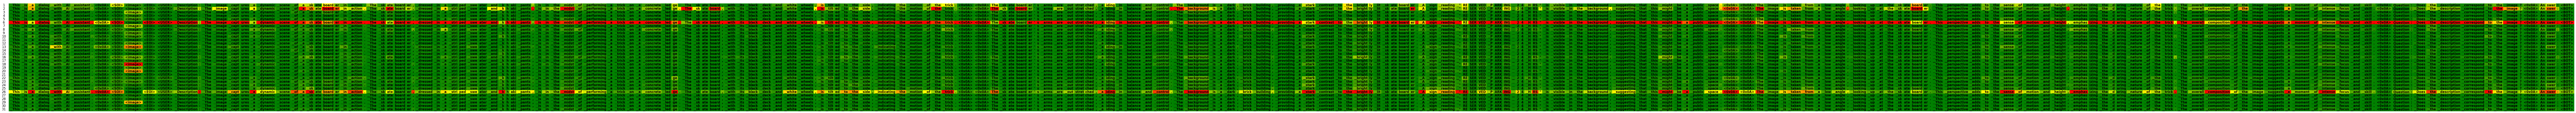

In [9]:
# Visualize tokenwise linearity for OmniFusion applied to the first example
buf, log_info = mllm_microscope.visualize_tokenwise_linearity(model_name=model_names[1], saving_path="./tokenwise_linearity")
print(log_info)

In [10]:
# Analyze LLaVA-NeXT intermediate embeddings
all_results = mllm_microscope.analyze_embeddings(model_name=model_names[0], ps=True, psmf=True, in_d=True, an=True)

Starting tests for the model LLaVA-NeXT...
Text embs shape:  torch.Size([15410, 4096])
Image embs shape:  torch.Size([16592, 4096])


LLaVA-NeXT image anisotropy: 100%|██████████| 32/32 [01:11<00:00,  2.24s/it]


In [ ]:
# Analyze OmniFusion intermediate embeddings
all_results = mllm_microscope.analyze_embeddings(model_name=model_names[1], ps=True, psmf=True, in_d=True, an=True)

In [ ]:
# Plot the obtained model scores
mllm_microscope.plot_results(saving_path="./linearity_results")

In [ ]:
# Visualize the intermediate model embeddings
mllm_microscope.visualize_intermediate_embeddings(saving_path="./visualization")